In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
sd = pd.read_csv('ca_san_diego_2020_04_01.csv')
print("{0} records in San Diego".format(len(sd)))
sd.head()

383027 records in San Diego


,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,...,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,...,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,...,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,...,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,...,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,...,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC


In [2]:
# clean up data
sd['date'] =  pd.to_datetime(sd['date'], format='%Y-%m-%d')
sd = sd[~sd['service_area'].isin(['Unknown', 'County', 'Bulletin'])]
sd = sd.dropna(subset=['date'])


In [3]:
sd['outcome'].value_counts(normalize=True)

citation    0.635827
warning     0.350091
arrest      0.014083
Name: outcome, dtype: float64

In [4]:
sd['outcome'].isnull().sum() / len(sd)

0.10132825996867717

In [5]:
def allocate_by_rate(df, officers=100, obedience=0.5):
    officers_ob = int(np.ceil(officers * obedience))
    officers_non = officers - officers_ob
    # print(officers_ob)
    ofcr_ob = np.floor(df.crime / df.crime.sum() * officers_ob).fillna(0)
    ofcr_non = np.zeros(len(df))
    
    rand_ofcr = np.random.choice(range(len(df)), size=officers_non)  # assigns officers to regions randomly
    for i in rand_ofcr:
        ofcr_non[i] += 1
    ofcr = ofcr_ob + ofcr_non
    return df.assign(ofcr=ofcr)


def how_many_discovered(df):
    
    def how_many(x):
        lam = max(x['rate'], 0)
        ppl_encountered = int(x['ofcr'] * (df['pop'].sum()/ df['ofcr'].sum()))#.astype(int)
        disc = np.random.poisson(lam=lam, size=ppl_encountered).sum()
        return min(disc, x['pop'])
    
    out = df.apply(how_many, axis=1)
    return df.assign(discovered=out)

In [6]:
# ofcr_non

In [7]:
# df = tmp
# obedience = 0.5
# officers = 100
# officers_ob = int(officers * obedience)
# officers_non = officers - officers_ob

# ofcr_ob = np.floor(df.crime / df.crime.sum() * officers_ob).fillna(0)

# ofcr_non = np.zeros(len(df))
# rand_ofcr = np.random.choice(range(len(df)), size=officers_non)  # assigns officers to regions randomly
# for i in rand_ofcr:
#   ofcr_non[i] += 1
# # ofcr_non.index = range(len(df))


# # print(ofcr_ob)
# ofcr = ofcr_ob + ofcr_non
# # print(ofcr_ob)
# print(ofcr_ob)
# print(ofcr_non)
# print(ofcr)

<AxesSubplot:xlabel='date'>

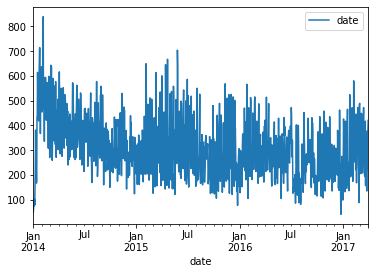

In [27]:
time_mask = (sd['date'].dt.year == 2014) & (sd['date'].dt.month == 1) & (sd['date'].dt.day == 0 + 1)
sd.groupby('date').agg({'date':'count'}).plot()
# sd.loc[time_mask]

In [8]:
# features for model: date, service area, crime rate
# model predicts whether officer should search vehicle 
# crime/ground truth determined by contraband_found

def crime_rate_of_day(sd, col):
    # "crime rate" is determined by contraband_found

    crime_rate = sd.groupby('service_area')[col].apply(lambda x: np.sum(x)/ x.count())
    #print(crime_rate)
    density = sd.groupby('service_area')['raw_row_number'].count()

    d = {'service_area':density.index.tolist(), 'pop': density.tolist(), 'rate': crime_rate.tolist()}
    sd_crime = pd.DataFrame(data=d)

    sd_crime['crime'] = sd_crime['pop']*sd_crime['rate']

    return sd_crime




for t in range(52):

    # is this supposed to be a closed system after the first iteration...
    if t == 0:
        time_mask = (sd['date'].dt.year == 2014) & (sd['date'].dt.isocalendar().week == t+1)
        sd_tmp = sd[time_mask]
        sd_crime = crime_rate_of_day(sd_tmp, 'citation_issued')
        tmp = sd_crime

    tmp = allocate_by_rate(tmp)
    tmp = how_many_discovered(tmp)

    # make dataset look like window t - 1's prediction 
    tmp = tmp.assign(
        rate=(tmp.discovered / tmp['pop']),
        crime=tmp.discovered
    )

    tmp = tmp.assign(t=t)
    tmp = tmp.assign(date = "Week {0}".format(t+1))
    if t == 0 or t == 51:
        display(tmp)

tmp['pop'].sum()

,service_area,pop,rate,crime,ofcr,discovered,t,date
0,110,74,1.000000,74,8.0,74,0,Week 1
1,120,109,0.348624,38,6.0,38,0,Week 1
2,230,54,0.685185,37,4.0,37,0,Week 1
3,240,76,0.671053,51,6.0,51,0,Week 1
4,310,79,0.607595,48,8.0,48,0,Week 1
5,320,57,0.701754,40,4.0,40,0,Week 1
6,430,52,0.173077,9,2.0,9,0,Week 1
7,440,48,1.000000,48,6.0,48,0,Week 1
8,510,32,0.031250,1,1.0,1,0,Week 1
9,520,79,0.810127,64,7.0,64,0,Week 1


,service_area,pop,rate,crime,ofcr,discovered,t,date
0,110,74,0.0,0,4.0,0,51,Week 52
1,120,109,0.0,0,5.0,0,51,Week 52
2,230,54,0.0,0,4.0,0,51,Week 52
3,240,76,1.0,76,14.0,76,51,Week 52
4,310,79,0.0,0,2.0,0,51,Week 52
5,320,57,0.0,0,2.0,0,51,Week 52
6,430,52,0.0,0,0.0,0,51,Week 52
7,440,48,1.0,48,9.0,48,51,Week 52
8,510,32,0.0,0,2.0,0,51,Week 52
9,520,79,1.0,79,14.0,79,51,Week 52


1070

In [29]:
### MODEL 1

# We take the first week of the actual dataset and we train a regression model on this subset using service area, crime rate as features. 
# The model we train will be Window 1's model and we take this model to predict a crime rate for Window 2. We will treat predicted crime rate
# for Window 2 as actual crime rate for Window 2 and call allocate_officers() and discover() on the crime rate. We compile this into a df that looks
# like the above and feed it into the regression model again. 



### MODEL 2

# Train on first week's data, classify on second week to determine how many officers to send to the next week.  Next week we have a discovered amount of crime based on our predictions, row by row we can flip labels if needed,
# then use that next week's data to classify on the third week.  Continue this process for all 52 weeks.


## Next Steps: Use neighborhood instead of 

In [9]:
import os
from pdfreader import SimplePDFViewer
from tqdm import tqdm
tqdm.pandas()

import pdfreader
import urllib.request

sd = pd.read_csv('ca_san_diego_2020_04_01.csv')


def get_total_population(year, div_num):
    fname = f'sd_data/{year}/sd_pop_division_{div_num}.pdf'
    fd = open(fname, 'rb')
    viewer = SimplePDFViewer(fd)
    viewer.render()
    return int(viewer.canvas.strings[3].replace(',',''))
# Convert service areas to division
unaccounted_service_areas = list(set(sd.service_area.unique()) - set(['110', '120', '230', 
                                     '240', '310', '320', 
                                     '430', '440', '510', 
                                     '520', '530', '610', 
                                     '620', '710', '720',
                                     '810', '820', '830', 
                                      '930']))

map_division_name = {
    '110' : 'Northern',
    '120' : 'Northern',
    '230' : 'Northeastern',
    '240' : 'Northeastern', 
    '310' : 'Eastern',
    '320' : 'Eastern',
    '430' : 'Southeastern',
    '440' : 'Southeastern',
    '510' : 'Central',
    '520' : 'Central', 
    '530' : 'Central', 
    '610' : 'Western',
    '620' : 'Western',
    '710' : 'Southern',
    '720' : 'Southern',
    '810' : 'Midcity',
    '820' : 'Midcity',
    '830' : 'Midcity',
    '930' : 'Northwestern'
}

sd = sd[~sd['service_area'].isin(unaccounted_service_areas)]
sd = sd.replace({'service_area': map_division_name})
sd = sd.rename(columns={'service_area': 'division'})
sd['division'] = sd['division'].str.upper()
map_division_num = {
    'NORTHERN' : 1, 
    'NORTHEASTERN' : 2, 
    'EASTERN' : 3, 
    'SOUTHEASTERN' : 4, 
    'CENTRAL' : 5, 
    'WESTERN' : 6, 
    'SOUTHERN' : 7, 
    'MIDCITY' : 8,
    'NORTHWESTERN' : 9
}


sd['div_num'] = sd.loc[:, 'division']
sd = sd.replace({'div_num': map_division_num})

# clean up data
sd['date'] =  pd.to_datetime(sd['date'], format='%Y-%m-%d')
sd = sd.dropna(subset=['date'])

# determine crime
sd['fruitful_search'] = sd[['arrest_made', 'citation_issued', 'contraband_found']].any(axis=1)

pdf_path = ""
def download_file(download_url, filename):
    response = urllib.request.urlopen(download_url)    
    file = open(filename + ".pdf", 'wb')
    file.write(response.read())
    file.close()

# if os.path.isdir('sd_data') == False: os.mkdir('sd_data')
# for year in range(2014, 2017):
#     if os.path.isdir(f'sd_data/{year}') == False: os.mkdir(f'sd_data/{year}')
#     for division in range(1, 10):
#         url = f'https://datasurfer.sandag.org/download/sandag_estimate_{year}_sdcouncil_{division}.pdf'
#         download_file(url, f'sd_data/{year}/sd_pop_division_{division}')

# get year
sd['year'] = sd['date'].dt.year

sd = sd[sd['year']!=2017].reset_index(drop=True)

sd_pop = sd[['year', 'div_num']].drop_duplicates().sort_values(by=['year', 'div_num']).reset_index(drop=True)
sd_pop['total_population'] = sd_pop.progress_apply(lambda x: get_total_population(x['year'], x['div_num']), axis=1)

sd['total_pop'] =  sd.loc[:, ['year', 'div_num']].merge(sd_pop, how='left').loc[:, 'total_population']

C:\Users\jdlevy\Anaconda3\lib\site-packages\tqdm\std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.83it/s]


In [ ]:
month_1 = sd[]

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import precision_score

In [42]:
weekdays=[x+'day' for x in ['Sun', 'Mon', 'Tues', 'Wednes', 'Thurs', 'Fri', 'Satur']]
day_of_week_dict = dict(zip(range(7), weekdays))

time_of_day = {i:'Morning' for i in range(24) if i in list(range(5, 12))}
time_of_day.update({i:'Afternoon' for i in range(24) if i in list(range(12, 18))})
time_of_day.update({i:'Evening' for i in range(24) if i in list(range(18, 24))})
time_of_day.update({i:'Overnight' for i in range(24) if i in list(range(6))})

In [175]:
def preprocessing_data(data, target='search_conducted', std=True):
    time_x = data.copy()[['date', 'time', 'division', 'subject_race', 'subject_age', 'subject_sex']]
    time_x['weekday'] = time_x['date'].dt.dayofweek.replace(day_of_week_dict)
    time_x['isWeekday'] = time_x['date'].dt.dayofweek.isin(range(1, 6))
    time_x['time_of_day'] = time_x['time'].astype('datetime64').dt.hour.replace(time_of_day)
#     time_x['time_of_day'] = time_x['time'].astype('datetime64').dt.hour
    time_x = pd.get_dummies(data=time_x, columns=[ 'weekday', 'division', 'time_of_day'])
    X = time_x.drop(['date', 'time', 'subject_race', 'subject_sex'], axis=1)
#     if std:
# #         print(.shape)
#         X['subject_age'] = StandardScaler().fit_transform(X[['subject_age']])
    X = X.dropna()#X.isnull()]
    y = data.loc[X.index, target]
    return X, y

In [176]:
def predictive_policing_pipeline(data, target='search_conducted', std=True):

    X, y = preprocessing_data(data, target, std)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#     print(X_train.isnull().sum())
    svm = SVC(class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
#     print(y_pred)
    display(sum(y_pred))
    
    pred_week_x2 = data.loc[X_test.index].copy()
    pred_week_x2[f'pred_{target}'] = y_pred
#     predictions = pred_week_x2.groupby('division').agg({f'pred_{target}':['sum']})
#     predictions['alloc'] = predictions[f'pred_{target}']['sum']/predictions[f'pred_{target}']['sum'].sum()
    
    return svm, X_test, y_test

In [10]:
month1 = sd[(sd['date'].dt.year == 2014) & (sd['date'].dt.month == 1)]
month2 = sd[(sd['date'].dt.year == 2014) & (sd['date'].dt.month == 2)]

In [14]:
month1.groupby('division').apply(len)

division
CENTRAL          997
EASTERN         1510
MIDCITY         1611
NORTHEASTERN    1509
NORTHERN        1296
NORTHWESTERN     826
SOUTHEASTERN    1209
SOUTHERN        1293
WESTERN         1756
dtype: int64

In [13]:
month1.groupby('division').agg({'fruitful_search':'mean'})

,fruitful_search
division,
CENTRAL,0.564694
EASTERN,0.633775
MIDCITY,0.490999
NORTHEASTERN,0.549370
NORTHERN,0.614198
NORTHWESTERN,0.510896
SOUTHEASTERN,0.458230
SOUTHERN,0.638051
WESTERN,0.575740


In [178]:
# svm, X_test, y_test = predictive_policing_pipeline(month1)

In [ ]:
plot_confusion_matrix(svm, X_test, y_test, normalize=None)

In [439]:
X_2, y_2 = preprocessing_data(month2)
y_2_pred = svm.predict(X_2)

In [440]:
sum(y_2_pred) / len(y_2)

0.30612395656349267

In [373]:
# time_of_day

In [305]:
print(report)

              precision    recall  f1-score   support

       False       0.47      0.38      0.42       105
        True       0.63      0.71      0.67       157

    accuracy                           0.58       262
   macro avg       0.55      0.54      0.54       262
weighted avg       0.56      0.58      0.57       262



In [299]:
classification_report?

In [221]:
week_1 = sd[(sd['date'].dt.year == 2014) & (sd['date'].dt.isocalendar().week == 1)]
week_2 = sd[(sd['date'].dt.year == 2014) & (sd['date'].dt.isocalendar().week == 2)]

In [222]:
# lr, X_test, y_test, y_pred = weekly_pipeline(week_1)

In [223]:
pred_week_2 = week_1.loc[X_test.index].copy()
pred_week_2['pred_fruitful'] = y_pred

In [224]:
predictions = pred_week_2.groupby('division').agg({'pred_fruitful':['sum']})
predictions['alloc'] = predictions['pred_fruitful']['sum']/predictions['pred_fruitful']['sum'].sum()
predictions

,pred_fruitful,alloc
,sum,
division,,
CENTRAL,22,0.125000
EASTERN,20,0.113636
MIDCITY,16,0.090909
NORTHEASTERN,26,0.147727
NORTHERN,34,0.193182
NORTHWESTERN,3,0.017045
SOUTHEASTERN,14,0.079545
SOUTHERN,24,0.136364


In [225]:
predictions['alloc']

division
CENTRAL         0.125000
EASTERN         0.113636
MIDCITY         0.090909
NORTHEASTERN    0.147727
NORTHERN        0.193182
NORTHWESTERN    0.017045
SOUTHEASTERN    0.079545
SOUTHERN        0.136364
WESTERN         0.096591
Name: alloc, dtype: float64

In [ ]:
### QUESTION: how do we change the proportion of stops by area for each time window?

In [179]:
def allocate_by_rate(df, officers=1800, obedience=1):
    officers_ob = int(np.ceil(officers * obedience))
    officers_non = officers - officers_ob
    # print(officers_ob)
    ofcr_ob = np.floor(df.crime / df.crime.sum() * officers_ob).fillna(0)
    ofcr_non = np.zeros(len(df))
    
    rand_ofcr = np.random.choice(range(len(df)), size=officers_non)  # assigns officers to regions randomly
    for i in rand_ofcr:
        ofcr_non[i] += 1
    ofcr = ofcr_ob + ofcr_non
    return df.assign(ofcr=ofcr)


def search_modifier(svm, data, crime, target='fruitful_search', crime_target='fruitful_search', flip_rate=0.10):
    # if obedience is observed: officer agrees with the prediction... in the case that the prediction is 1
    X, y = preprocessing_data(data, target)
    y_pred = svm.predict(X)
    pred_col = f'pred_{target}'
    data = data.loc[X.index]
    data[pred_col] = y_pred
#     print(len(data))
    
    data_filt = data.loc[(data[pred_col]==data[target]) | ((data[target]==0)&(data[pred_col]==1))]
#     data_filt.loc[data_filt[pred_col]==1].sample(frac=obedience) # the officer only agrees with the prediction to search at rate 'obedience'
    data_filt.loc[((data['search_conducted']==0)&(data[pred_col]==1)), 'search_conducted'] = True
    
    data_filt.loc[((data[target]==0)&(data[pred_col]==1)), crime_target] = \
        data_filt.loc[((data[target]==0)&(data[pred_col]==1)), crime_target].apply(lambda x: True if np.random.uniform() < flip_rate else False)
    

    
    crime['ofcr_prop'] = crime['ofcr']/sum(crime['ofcr'])
    crime['num_rows_opt'] = np.ceil(len(data_filt)*tmp['ofcr_prop'])
#     display(X_filt)
    len_pd = data_filt.groupby('division').apply(len)
    len_pd.name = 'num_rows_act'
#     display(len_pd)
    crime = crime.merge(len_pd, left_on='division', right_index=True, how='left')
#     display(crime)
    not_enough_rows = crime.loc[(crime['num_rows_act']<crime['num_rows_opt']), ['num_rows_opt','num_rows_act']]
    if len(not_enough_rows) > 0:
        diff = (not_enough_rows['num_rows_opt'] - not_enough_rows['num_rows_act'])/not_enough_rows['num_rows_opt']
        limiting_row = diff.idxmax()
#         print(diff)
        print(f'Raw amount of rows: {crime["num_rows_act"].sum()}')
        new_max = np.floor(crime.loc[limiting_row, "num_rows_act"]/crime.loc[limiting_row, "ofcr_prop"])
        print(f'New max number of rows: {new_max}')
    else:
        new_max = len(data_filt)
        
    display(crime)
#     new_max = len(data_filt)
    
#     crime['']
    div_dict = dict(zip(crime['division'].values, crime['ofcr_prop'].values))
    ret_df = pd.DataFrame()
    for division in crime['division'].unique():
#         print('Here is crime stats:')
        n_samp = int(crime.loc[crime['division']==division,'ofcr_prop']*new_max)
        print(division)
        print(f'N: {n_samp}')
        div_samp = data_filt.loc[data_filt['division']==division].sample(n=n_samp, replace=False)
        ret_df = ret_df.append(div_samp)
    return ret_df


def allocate_by_prediction(df, tmp, officers=1800, obedience=0.75):
    
    predictions = weekly_pipeline(df)
    
    
    officers_ob = int(np.ceil(officers * obedience))
    officers_non = officers - officers_ob
    # print(officers_ob)
    ofcr_ob = np.floor(predictions['alloc']*officers_ob).fillna(0)
#     ofcr_ob = np.floor(df.crime / df.crime.sum() * officers_ob).fillna(0)
    ofcr_non = np.zeros(len(predictions))
#     print(ofcr_ob)
    rand_ofcr = np.random.choice(range(len(predictions)), size=officers_non)  # assigns officers to regions randomly
    for i in rand_ofcr:
        ofcr_non[i] += 1
    ofcr_non = pd.Series(data=ofcr_non, index=ofcr_ob.index)
#     print(ofcr_non)
    ofcr = ofcr_ob + ofcr_non
#     print(predictions)
#     predictions = predictions.merge(tmp, left_index=True, right_on='division').set_index('division')
    tmp = tmp.set_index('division')
    return tmp.assign(ofcr=ofcr, alloc=predictions['alloc'])


def resample_pred(df, tmp):
    display(df)
    display(tmp)


def pred_how_many_discovered(df):
    
    def how_many(x):
        lam = max(x['rate'], 0)
#         print('People per officer:',(df['pop'].sum()/ df['ofcr'].sum()))
        ppl_encountered = int(x['ofcr'] * (750))#.astype(int)
        disc = np.random.poisson(lam=lam, size=ppl_encountered).sum()
        return min(disc, x['pop'])
    
    out = df.apply(how_many, axis=1)
    return df.assign(discovered=out)

In [180]:
# t = 0
# crime_target = 'arrest_made'
# for t in range(2):
#     time_mask = (sd['date'].dt.year ==int(2014+np.floor(t/12))) & (sd['date'].dt.month == (t%12)+1)
#     sd_tmp = sd[time_mask]
#     if t == 0:
#         sd_crime = crime_rate_of_day(sd_tmp, crime_target)
#     if t > 0:
#         X_filt = search_modifier(svm, sd_tmp, tmp, crime_target=crime_target, flip_rate=0.25)
#         sd_crime = crime_rate_of_day(X_filt, crime_target)
#     tmp = allocate_by_rate(sd_crime, officers=1800, obedience=1)


In [181]:
# X_filt.groupby('division').apply(lambda x: len(x)/len(X_filt))

In [182]:
# X_filt

In [183]:
# X_filt = search_modifier(svm, sd_tmp, sd_crime)

In [184]:
# X_filt['search_conducted'].mean()

In [185]:
import warnings
warnings.simplefilter(action='ignore')

In [503]:
# for t in range(36):
#     print(t, np.floor(t/12))

In [173]:
time_mask = (sd['date'].dt.year == (2014+np.floor(t/12))) & (sd['date'].dt.month == (t%12)+1)
sd_tmp = sd[time_mask]
len(sd_tmp)

7327

In [235]:
# features for model: date, service area, crime rate
# model predicts whether officer should search vehicle 
# crime/ground truth determined by contraband_found

def crime_rate_of_day(sd, col):
    # "crime rate" is determined by contraband_found

    crime_rate = sd.groupby('division').apply(lambda x: np.sum(x[col])/ x['total_pop'].unique()[0])
#     print(crime_rate)
    population = sd.groupby('division').apply(lambda x: x['total_pop'].unique()[0])

    d = {'division':population.index.tolist(), 'pop': population.tolist(), 'rate': crime_rate.tolist()}
    sd_crime = pd.DataFrame(data=d)

    sd_crime['crime'] = sd_crime['pop']*sd_crime['rate']
    
#     sd_crime['predi'] = 
    return sd_crime




# for t in range(52):

#     # is this supposed to be a closed system after the first iteration...
#     if t == 0:
t = 0      
result_dict = {}
model_dict = {}
X_dict = {}
y_dict = {}
X_filt_dict = {}
crime_target = 'fruitful_search'
ob = 0.9
ob_pct = int(ob*100)
num_ofcr = 1800
for t in range(36):
    time_mask = (sd['date'].dt.year ==int(2014+np.floor(t/12))) & (sd['date'].dt.month == (t%12)+1)
    sd_tmp = sd[time_mask]
    if t == 0:
        sd_crime = crime_rate_of_day(sd_tmp, crime_target)
        X_filt_dict[t] = preprocessing_data(sd_tmp)
    if t > 0:
        X_filt = search_modifier(svm, sd_tmp, tmp, crime_target=crime_target, flip_rate=0.60)
        sd_crime = crime_rate_of_day(X_filt, crime_target)
        X_filt_dict[t] = X_filt
#     display(sd_crime)
    tmp = allocate_by_rate(sd_crime, officers=num_ofcr, obedience=ob)
    
#     tmp = sd_crime
#     display(tmp)
#     tmp = 
#     display(tmp)
#     pred_search(sd_tmp)
#     resample_pred(sd_crime, tmp)
    svm, X_test, y_test = predictive_policing_pipeline(sd_tmp)
    model_dict[t] = svm
    X_dict[t] = X_test
    y_dict[t] = y_test
    
#     sd_crime = crime_rate_of_day(sd_tmp, 'contraband_found')

    
#     break
#     tmp = how_many_discovered(tmp)

    tmp = tmp.assign(t=t)
    tmp = tmp.assign(date = "Month {0}".format(t+1))
    display(tmp)
    result_dict[t] = tmp
    print('Total Officers:', sum(tmp['ofcr']))
    
    # make dataset look like window t - 1's prediction 
#     tmp = tmp.assign(
#     rate=(tmp.discovered / tmp['pop']),
#     crime=tmp.discovered
#     )
#     if t == 0 or t == 51:
#         display(tmp)

tmp['pop'].sum()

1773

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.003680,563.0,152.0,0,Month 1
1,EASTERN,164633,0.005813,957.0,243.0,0,Month 1
2,MIDCITY,145073,0.005452,791.0,210.0,0,Month 1
3,NORTHEASTERN,154575,0.005363,829.0,222.0,0,Month 1
4,NORTHERN,158153,0.005033,796.0,214.0,0,Month 1
5,NORTHWESTERN,148077,0.002850,422.0,120.0,0,Month 1
6,SOUTHEASTERN,139207,0.003980,554.0,148.0,0,Month 1
7,SOUTHERN,154473,0.005341,825.0,219.0,0,Month 1
8,WESTERN,144302,0.007006,1011.0,268.0,0,Month 1


Total Officers: 1796.0
Raw amount of rows: 10346
New max number of rows: 7716.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.003680,563.0,152.0,0,Month 1,0.084633,876.0,1072
1,EASTERN,164633,0.005813,957.0,243.0,0,Month 1,0.135301,1400.0,1044
2,MIDCITY,145073,0.005452,791.0,210.0,0,Month 1,0.116927,1210.0,1614
3,NORTHEASTERN,154575,0.005363,829.0,222.0,0,Month 1,0.123608,1279.0,1175
4,NORTHERN,158153,0.005033,796.0,214.0,0,Month 1,0.119154,1233.0,1039
5,NORTHWESTERN,148077,0.002850,422.0,120.0,0,Month 1,0.066815,692.0,620
6,SOUTHEASTERN,139207,0.003980,554.0,148.0,0,Month 1,0.082405,853.0,1041
7,SOUTHERN,154473,0.005341,825.0,219.0,0,Month 1,0.121938,1262.0,988
8,WESTERN,144302,0.007006,1011.0,268.0,0,Month 1,0.149220,1544.0,1753


CENTRAL
N: 653
EASTERN
N: 1043
MIDCITY
N: 902
NORTHEASTERN
N: 953
NORTHERN
N: 919
NORTHWESTERN
N: 515
SOUTHEASTERN
N: 635
SOUTHERN
N: 940
WESTERN
N: 1151


1990

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002785,426.0,159.0,1,Month 2
1,EASTERN,164633,0.003802,626.0,226.0,1,Month 2
2,MIDCITY,145073,0.004356,632.0,230.0,1,Month 2
3,NORTHEASTERN,154575,0.002950,456.0,174.0,1,Month 2
4,NORTHERN,158153,0.003844,608.0,226.0,1,Month 2
5,NORTHWESTERN,148077,0.001796,266.0,108.0,1,Month 2
6,SOUTHEASTERN,139207,0.002866,399.0,153.0,1,Month 2
7,SOUTHERN,154473,0.004208,650.0,232.0,1,Month 2
8,WESTERN,144302,0.005537,799.0,286.0,1,Month 2


Total Officers: 1794.0
Raw amount of rows: 9895
New max number of rows: 7064.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002785,426.0,159.0,1,Month 2,0.088629,877.0,1594
1,EASTERN,164633,0.003802,626.0,226.0,1,Month 2,0.125975,1247.0,974
2,MIDCITY,145073,0.004356,632.0,230.0,1,Month 2,0.128205,1269.0,1118
3,NORTHEASTERN,154575,0.002950,456.0,174.0,1,Month 2,0.096990,960.0,1276
4,NORTHERN,158153,0.003844,608.0,226.0,1,Month 2,0.125975,1247.0,890
5,NORTHWESTERN,148077,0.001796,266.0,108.0,1,Month 2,0.060201,596.0,701
6,SOUTHEASTERN,139207,0.002866,399.0,153.0,1,Month 2,0.085284,844.0,877
7,SOUTHERN,154473,0.004208,650.0,232.0,1,Month 2,0.129320,1280.0,1158
8,WESTERN,144302,0.005537,799.0,286.0,1,Month 2,0.159420,1578.0,1307


CENTRAL
N: 626
EASTERN
N: 889
MIDCITY
N: 905
NORTHEASTERN
N: 685
NORTHERN
N: 889
NORTHWESTERN
N: 425
SOUTHEASTERN
N: 602
SOUTHERN
N: 913
WESTERN
N: 1126


1768

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002883,441.0,178.0,2,Month 3
1,EASTERN,164633,0.003359,553.0,208.0,2,Month 3
2,MIDCITY,145073,0.004639,673.0,254.0,2,Month 3
3,NORTHEASTERN,154575,0.002284,353.0,136.0,2,Month 3
4,NORTHERN,158153,0.003712,587.0,219.0,2,Month 3
5,NORTHWESTERN,148077,0.001378,204.0,95.0,2,Month 3
6,SOUTHEASTERN,139207,0.002888,402.0,156.0,2,Month 3
7,SOUTHERN,154473,0.004557,704.0,257.0,2,Month 3
8,WESTERN,144302,0.005419,782.0,293.0,2,Month 3


Total Officers: 1796.0
Raw amount of rows: 9057
New max number of rows: 6233.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002883,441.0,178.0,2,Month 3,0.099109,898.0,1018
1,EASTERN,164633,0.003359,553.0,208.0,2,Month 3,0.115813,1049.0,917
2,MIDCITY,145073,0.004639,673.0,254.0,2,Month 3,0.141425,1281.0,1254
3,NORTHEASTERN,154575,0.002284,353.0,136.0,2,Month 3,0.075724,686.0,1187
4,NORTHERN,158153,0.003712,587.0,219.0,2,Month 3,0.121938,1105.0,978
5,NORTHWESTERN,148077,0.001378,204.0,95.0,2,Month 3,0.052895,480.0,724
6,SOUTHEASTERN,139207,0.002888,402.0,156.0,2,Month 3,0.086860,787.0,790
7,SOUTHERN,154473,0.004557,704.0,257.0,2,Month 3,0.143096,1297.0,892
8,WESTERN,144302,0.005419,782.0,293.0,2,Month 3,0.163140,1478.0,1297


CENTRAL
N: 617
EASTERN
N: 721
MIDCITY
N: 881
NORTHEASTERN
N: 471
NORTHERN
N: 760
NORTHWESTERN
N: 329
SOUTHEASTERN
N: 541
SOUTHERN
N: 891
WESTERN
N: 1016


1569

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002903,444.0,192.0,3,Month 4
1,EASTERN,164633,0.002758,454.0,208.0,3,Month 4
2,MIDCITY,145073,0.004046,587.0,258.0,3,Month 4
3,NORTHEASTERN,154575,0.001352,209.0,102.0,3,Month 4
4,NORTHERN,158153,0.003218,509.0,225.0,3,Month 4
5,NORTHWESTERN,148077,0.000959,142.0,80.0,3,Month 4
6,SOUTHEASTERN,139207,0.002486,346.0,156.0,3,Month 4
7,SOUTHERN,154473,0.004052,626.0,269.0,3,Month 4
8,WESTERN,144302,0.004809,694.0,306.0,3,Month 4


Total Officers: 1796.0
Raw amount of rows: 8212
New max number of rows: 6096.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002903,444.0,192.0,3,Month 4,0.106904,878.0,1435
1,EASTERN,164633,0.002758,454.0,208.0,3,Month 4,0.115813,952.0,706
2,MIDCITY,145073,0.004046,587.0,258.0,3,Month 4,0.143653,1180.0,1138
3,NORTHEASTERN,154575,0.001352,209.0,102.0,3,Month 4,0.056793,467.0,825
4,NORTHERN,158153,0.003218,509.0,225.0,3,Month 4,0.125278,1029.0,908
5,NORTHWESTERN,148077,0.000959,142.0,80.0,3,Month 4,0.044543,366.0,448
6,SOUTHEASTERN,139207,0.002486,346.0,156.0,3,Month 4,0.086860,714.0,713
7,SOUTHERN,154473,0.004052,626.0,269.0,3,Month 4,0.149777,1230.0,923
8,WESTERN,144302,0.004809,694.0,306.0,3,Month 4,0.170379,1400.0,1116


CENTRAL
N: 651
EASTERN
N: 705
MIDCITY
N: 875
NORTHEASTERN
N: 346
NORTHERN
N: 763
NORTHWESTERN
N: 271
SOUTHEASTERN
N: 529
SOUTHERN
N: 913
WESTERN
N: 1038


1308

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.003216,492.0,222.0,4,Month 5
1,EASTERN,164633,0.002618,431.0,195.0,4,Month 5
2,MIDCITY,145073,0.004260,618.0,275.0,4,Month 5
3,NORTHEASTERN,154575,0.000990,153.0,80.0,4,Month 5
4,NORTHERN,158153,0.003130,495.0,227.0,4,Month 5
5,NORTHWESTERN,148077,0.000939,139.0,74.0,4,Month 5
6,SOUTHEASTERN,139207,0.002644,368.0,172.0,4,Month 5
7,SOUTHERN,154473,0.003936,608.0,273.0,4,Month 5
8,WESTERN,144302,0.004269,616.0,279.0,4,Month 5


Total Officers: 1797.0
Raw amount of rows: 6868
New max number of rows: 5127.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.003216,492.0,222.0,4,Month 5,0.123539,849.0,816
1,EASTERN,164633,0.002618,431.0,195.0,4,Month 5,0.108514,746.0,703
2,MIDCITY,145073,0.004260,618.0,275.0,4,Month 5,0.153033,1052.0,1015
3,NORTHEASTERN,154575,0.000990,153.0,80.0,4,Month 5,0.044519,306.0,695
4,NORTHERN,158153,0.003130,495.0,227.0,4,Month 5,0.126322,868.0,750
5,NORTHWESTERN,148077,0.000939,139.0,74.0,4,Month 5,0.041180,283.0,429
6,SOUTHEASTERN,139207,0.002644,368.0,172.0,4,Month 5,0.095715,658.0,692
7,SOUTHERN,154473,0.003936,608.0,273.0,4,Month 5,0.151920,1044.0,779
8,WESTERN,144302,0.004269,616.0,279.0,4,Month 5,0.155259,1067.0,989


CENTRAL
N: 633
EASTERN
N: 556
MIDCITY
N: 784
NORTHEASTERN
N: 228
NORTHERN
N: 647
NORTHWESTERN
N: 211
SOUTHEASTERN
N: 490
SOUTHERN
N: 778
WESTERN
N: 796


1231

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002896,443.0,248.0,5,Month 6
1,EASTERN,164633,0.001883,310.0,180.0,5,Month 6
2,MIDCITY,145073,0.003922,569.0,316.0,5,Month 6
3,NORTHEASTERN,154575,0.000582,90.0,62.0,5,Month 6
4,NORTHERN,158153,0.002289,362.0,215.0,5,Month 6
5,NORTHWESTERN,148077,0.000628,93.0,70.0,5,Month 6
6,SOUTHEASTERN,139207,0.002177,303.0,172.0,5,Month 6
7,SOUTHERN,154473,0.003340,516.0,295.0,5,Month 6
8,WESTERN,144302,0.002973,429.0,238.0,5,Month 6


Total Officers: 1796.0
Raw amount of rows: 6628
New max number of rows: 4237.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002896,443.0,248.0,5,Month 6,0.138085,916.0,862
1,EASTERN,164633,0.001883,310.0,180.0,5,Month 6,0.100223,665.0,467
2,MIDCITY,145073,0.003922,569.0,316.0,5,Month 6,0.175947,1167.0,841
3,NORTHEASTERN,154575,0.000582,90.0,62.0,5,Month 6,0.034521,229.0,685
4,NORTHERN,158153,0.002289,362.0,215.0,5,Month 6,0.119710,794.0,788
5,NORTHWESTERN,148077,0.000628,93.0,70.0,5,Month 6,0.038976,259.0,494
6,SOUTHEASTERN,139207,0.002177,303.0,172.0,5,Month 6,0.095768,635.0,719
7,SOUTHERN,154473,0.003340,516.0,295.0,5,Month 6,0.164254,1089.0,696
8,WESTERN,144302,0.002973,429.0,238.0,5,Month 6,0.132517,879.0,1076


CENTRAL
N: 585
EASTERN
N: 424
MIDCITY
N: 745
NORTHEASTERN
N: 146
NORTHERN
N: 507
NORTHWESTERN
N: 165
SOUTHEASTERN
N: 405
SOUTHERN
N: 695
WESTERN
N: 561


1357

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002700,413.0,290.0,6,Month 7
1,EASTERN,164633,0.001063,175.0,134.0,6,Month 7
2,MIDCITY,145073,0.003667,532.0,379.0,6,Month 7
3,NORTHEASTERN,154575,0.000388,60.0,55.0,6,Month 7
4,NORTHERN,158153,0.001650,261.0,200.0,6,Month 7
5,NORTHWESTERN,148077,0.000412,61.0,56.0,6,Month 7
6,SOUTHEASTERN,139207,0.001983,276.0,204.0,6,Month 7
7,SOUTHERN,154473,0.002033,314.0,226.0,6,Month 7
8,WESTERN,144302,0.002446,353.0,250.0,6,Month 7


Total Officers: 1794.0
Raw amount of rows: 7574
New max number of rows: 5074.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002700,413.0,290.0,6,Month 7,0.161650,1225.0,908
1,EASTERN,164633,0.001063,175.0,134.0,6,Month 7,0.074693,566.0,786
2,MIDCITY,145073,0.003667,532.0,379.0,6,Month 7,0.211260,1601.0,1072
3,NORTHEASTERN,154575,0.000388,60.0,55.0,6,Month 7,0.030658,233.0,751
4,NORTHERN,158153,0.001650,261.0,200.0,6,Month 7,0.111483,845.0,1113
5,NORTHWESTERN,148077,0.000412,61.0,56.0,6,Month 7,0.031215,237.0,506
6,SOUTHEASTERN,139207,0.001983,276.0,204.0,6,Month 7,0.113712,862.0,758
7,SOUTHERN,154473,0.002033,314.0,226.0,6,Month 7,0.125975,955.0,761
8,WESTERN,144302,0.002446,353.0,250.0,6,Month 7,0.139353,1056.0,919


CENTRAL
N: 820
EASTERN
N: 378
MIDCITY
N: 1071
NORTHEASTERN
N: 155
NORTHERN
N: 565
NORTHWESTERN
N: 158
SOUTHEASTERN
N: 576
SOUTHERN
N: 639
WESTERN
N: 707


1323

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.003981,609.0,310.0,7,Month 8
1,EASTERN,164633,0.001470,242.0,131.0,7,Month 8
2,MIDCITY,145073,0.005170,750.0,376.0,7,Month 8
3,NORTHEASTERN,154575,0.000498,77.0,59.0,7,Month 8
4,NORTHERN,158153,0.002491,394.0,206.0,7,Month 8
5,NORTHWESTERN,148077,0.000520,77.0,57.0,7,Month 8
6,SOUTHEASTERN,139207,0.002830,394.0,205.0,7,Month 8
7,SOUTHERN,154473,0.002602,402.0,212.0,7,Month 8
8,WESTERN,144302,0.003139,453.0,238.0,7,Month 8


Total Officers: 1794.0
Raw amount of rows: 6309
New max number of rows: 4224.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.003981,609.0,310.0,7,Month 8,0.172798,1091.0,730
1,EASTERN,164633,0.001470,242.0,131.0,7,Month 8,0.073021,461.0,649
2,MIDCITY,145073,0.005170,750.0,376.0,7,Month 8,0.209588,1323.0,971
3,NORTHEASTERN,154575,0.000498,77.0,59.0,7,Month 8,0.032887,208.0,691
4,NORTHERN,158153,0.002491,394.0,206.0,7,Month 8,0.114827,725.0,780
5,NORTHWESTERN,148077,0.000520,77.0,57.0,7,Month 8,0.031773,201.0,594
6,SOUTHEASTERN,139207,0.002830,394.0,205.0,7,Month 8,0.114270,721.0,530
7,SOUTHERN,154473,0.002602,402.0,212.0,7,Month 8,0.118172,746.0,676
8,WESTERN,144302,0.003139,453.0,238.0,7,Month 8,0.132664,837.0,688


CENTRAL
N: 729
EASTERN
N: 308
MIDCITY
N: 885
NORTHEASTERN
N: 138
NORTHERN
N: 485
NORTHWESTERN
N: 134
SOUTHEASTERN
N: 482
SOUTHERN
N: 499
WESTERN
N: 560


1403

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.003295,504.0,325.0,8,Month 9
1,EASTERN,164633,0.000869,143.0,108.0,8,Month 9
2,MIDCITY,145073,0.004570,663.0,419.0,8,Month 9
3,NORTHEASTERN,154575,0.000433,67.0,57.0,8,Month 9
4,NORTHERN,158153,0.001821,288.0,190.0,8,Month 9
5,NORTHWESTERN,148077,0.000385,57.0,54.0,8,Month 9
6,SOUTHEASTERN,139207,0.002356,328.0,218.0,8,Month 9
7,SOUTHERN,154473,0.001962,303.0,205.0,8,Month 9
8,WESTERN,144302,0.002301,332.0,220.0,8,Month 9


Total Officers: 1796.0
Raw amount of rows: 6617
New max number of rows: 3381.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.003295,504.0,325.0,8,Month 9,0.180958,1198.0,713
1,EASTERN,164633,0.000869,143.0,108.0,8,Month 9,0.060134,398.0,818
2,MIDCITY,145073,0.004570,663.0,419.0,8,Month 9,0.233296,1544.0,789
3,NORTHEASTERN,154575,0.000433,67.0,57.0,8,Month 9,0.031737,211.0,701
4,NORTHERN,158153,0.001821,288.0,190.0,8,Month 9,0.105791,701.0,946
5,NORTHWESTERN,148077,0.000385,57.0,54.0,8,Month 9,0.030067,199.0,590
6,SOUTHEASTERN,139207,0.002356,328.0,218.0,8,Month 9,0.121381,804.0,502
7,SOUTHERN,154473,0.001962,303.0,205.0,8,Month 9,0.114143,756.0,707
8,WESTERN,144302,0.002301,332.0,220.0,8,Month 9,0.122494,811.0,851


CENTRAL
N: 611
EASTERN
N: 203
MIDCITY
N: 788
NORTHEASTERN
N: 107
NORTHERN
N: 357
NORTHWESTERN
N: 101
SOUTHEASTERN
N: 410
SOUTHERN
N: 385
WESTERN
N: 414


1257

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002935,449.0,336.0,9,Month 10
1,EASTERN,164633,0.000814,134.0,115.0,9,Month 10
2,MIDCITY,145073,0.003957,574.0,428.0,9,Month 10
3,NORTHEASTERN,154575,0.000388,60.0,69.0,9,Month 10
4,NORTHERN,158153,0.001650,261.0,208.0,9,Month 10
5,NORTHWESTERN,148077,0.000270,40.0,42.0,9,Month 10
6,SOUTHEASTERN,139207,0.001990,277.0,217.0,9,Month 10
7,SOUTHERN,154473,0.001450,224.0,173.0,9,Month 10
8,WESTERN,144302,0.001857,268.0,207.0,9,Month 10


Total Officers: 1795.0
Raw amount of rows: 6967
New max number of rows: 3565.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002935,449.0,336.0,9,Month 10,0.187187,1305.0,871
1,EASTERN,164633,0.000814,134.0,115.0,9,Month 10,0.064067,447.0,930
2,MIDCITY,145073,0.003957,574.0,428.0,9,Month 10,0.238440,1662.0,871
3,NORTHEASTERN,154575,0.000388,60.0,69.0,9,Month 10,0.038440,268.0,757
4,NORTHERN,158153,0.001650,261.0,208.0,9,Month 10,0.115877,808.0,1013
5,NORTHWESTERN,148077,0.000270,40.0,42.0,9,Month 10,0.023398,164.0,549
6,SOUTHEASTERN,139207,0.001990,277.0,217.0,9,Month 10,0.120891,843.0,431
7,SOUTHERN,154473,0.001450,224.0,173.0,9,Month 10,0.096379,672.0,706
8,WESTERN,144302,0.001857,268.0,207.0,9,Month 10,0.115320,804.0,839


CENTRAL
N: 667
EASTERN
N: 228
MIDCITY
N: 850
NORTHEASTERN
N: 137
NORTHERN
N: 413
NORTHWESTERN
N: 83
SOUTHEASTERN
N: 430
SOUTHERN
N: 343
WESTERN
N: 411


1529

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.002831,433.0,325.0,10,Month 11
1,EASTERN,164633,0.000917,151.0,121.0,10,Month 11
2,MIDCITY,145073,0.003922,569.0,406.0,10,Month 11
3,NORTHEASTERN,154575,0.000492,76.0,73.0,10,Month 11
4,NORTHERN,158153,0.001884,298.0,216.0,10,Month 11
5,NORTHWESTERN,148077,0.000304,45.0,51.0,10,Month 11
6,SOUTHEASTERN,139207,0.002062,287.0,215.0,10,Month 11
7,SOUTHERN,154473,0.001411,218.0,169.0,10,Month 11
8,WESTERN,144302,0.002030,293.0,219.0,10,Month 11


Total Officers: 1795.0
Raw amount of rows: 6634
New max number of rows: 3877.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.002831,433.0,325.0,10,Month 11,0.181058,1202.0,811
1,EASTERN,164633,0.000917,151.0,121.0,10,Month 11,0.067409,448.0,927
2,MIDCITY,145073,0.003922,569.0,406.0,10,Month 11,0.226184,1501.0,877
3,NORTHEASTERN,154575,0.000492,76.0,73.0,10,Month 11,0.040669,270.0,876
4,NORTHERN,158153,0.001884,298.0,216.0,10,Month 11,0.120334,799.0,680
5,NORTHWESTERN,148077,0.000304,45.0,51.0,10,Month 11,0.028412,189.0,484
6,SOUTHEASTERN,139207,0.002062,287.0,215.0,10,Month 11,0.119777,795.0,476
7,SOUTHERN,154473,0.001411,218.0,169.0,10,Month 11,0.094150,625.0,702
8,WESTERN,144302,0.002030,293.0,219.0,10,Month 11,0.122006,810.0,801


CENTRAL
N: 701
EASTERN
N: 261
MIDCITY
N: 876
NORTHEASTERN
N: 157
NORTHERN
N: 466
NORTHWESTERN
N: 110
SOUTHEASTERN
N: 464
SOUTHERN
N: 365
WESTERN
N: 473


1173

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,152970,0.003308,506.0,321.0,11,Month 12
1,EASTERN,164633,0.001112,183.0,128.0,11,Month 12
2,MIDCITY,145073,0.004536,658.0,418.0,11,Month 12
3,NORTHEASTERN,154575,0.000556,86.0,74.0,11,Month 12
4,NORTHERN,158153,0.001960,310.0,203.0,11,Month 12
5,NORTHWESTERN,148077,0.000398,59.0,53.0,11,Month 12
6,SOUTHEASTERN,139207,0.002414,336.0,225.0,11,Month 12
7,SOUTHERN,154473,0.001385,214.0,152.0,11,Month 12
8,WESTERN,144302,0.002335,337.0,221.0,11,Month 12


Total Officers: 1795.0
Raw amount of rows: 6282
New max number of rows: 3510.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,152970,0.003308,506.0,321.0,11,Month 12,0.178830,1124.0,718
1,EASTERN,164633,0.001112,183.0,128.0,11,Month 12,0.071309,448.0,659
2,MIDCITY,145073,0.004536,658.0,418.0,11,Month 12,0.232869,1463.0,844
3,NORTHEASTERN,154575,0.000556,86.0,74.0,11,Month 12,0.041226,259.0,857
4,NORTHERN,158153,0.001960,310.0,203.0,11,Month 12,0.113092,711.0,870
5,NORTHWESTERN,148077,0.000398,59.0,53.0,11,Month 12,0.029526,186.0,535
6,SOUTHEASTERN,139207,0.002414,336.0,225.0,11,Month 12,0.125348,788.0,440
7,SOUTHERN,154473,0.001385,214.0,152.0,11,Month 12,0.084680,532.0,595
8,WESTERN,144302,0.002335,337.0,221.0,11,Month 12,0.123120,774.0,764


CENTRAL
N: 627
EASTERN
N: 250
MIDCITY
N: 817
NORTHEASTERN
N: 144
NORTHERN
N: 396
NORTHWESTERN
N: 103
SOUTHEASTERN
N: 439
SOUTHERN
N: 297
WESTERN
N: 432


1161

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.002677,418.0,322.0,12,Month 13
1,EASTERN,176014,0.000966,170.0,145.0,12,Month 13
2,MIDCITY,145864,0.003956,577.0,431.0,12,Month 13
3,NORTHEASTERN,156874,0.000523,82.0,74.0,12,Month 13
4,NORTHERN,161122,0.001657,267.0,215.0,12,Month 13
5,NORTHWESTERN,148108,0.000290,43.0,43.0,12,Month 13
6,SOUTHEASTERN,138500,0.001949,270.0,212.0,12,Month 13
7,SOUTHERN,157051,0.001159,182.0,149.0,12,Month 13
8,WESTERN,147791,0.001773,262.0,204.0,12,Month 13


Total Officers: 1795.0
Raw amount of rows: 6619
New max number of rows: 3764.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.002677,418.0,322.0,12,Month 13,0.179387,1188.0,702
1,EASTERN,176014,0.000966,170.0,145.0,12,Month 13,0.080780,535.0,1034
2,MIDCITY,145864,0.003956,577.0,431.0,12,Month 13,0.240111,1590.0,904
3,NORTHEASTERN,156874,0.000523,82.0,74.0,12,Month 13,0.041226,273.0,740
4,NORTHERN,161122,0.001657,267.0,215.0,12,Month 13,0.119777,793.0,921
5,NORTHWESTERN,148108,0.000290,43.0,43.0,12,Month 13,0.023955,159.0,458
6,SOUTHEASTERN,138500,0.001949,270.0,212.0,12,Month 13,0.118106,782.0,528
7,SOUTHERN,157051,0.001159,182.0,149.0,12,Month 13,0.083008,550.0,671
8,WESTERN,147791,0.001773,262.0,204.0,12,Month 13,0.113649,753.0,661


CENTRAL
N: 675
EASTERN
N: 304
MIDCITY
N: 903
NORTHEASTERN
N: 155
NORTHERN
N: 450
NORTHWESTERN
N: 90
SOUTHEASTERN
N: 444
SOUTHERN
N: 312
WESTERN
N: 427


1306

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.002773,433.0,310.0,13,Month 14
1,EASTERN,176014,0.001153,203.0,152.0,13,Month 14
2,MIDCITY,145864,0.004004,584.0,419.0,13,Month 14
3,NORTHEASTERN,156874,0.000459,72.0,66.0,13,Month 14
4,NORTHERN,161122,0.001887,304.0,222.0,13,Month 14
5,NORTHWESTERN,148108,0.000257,38.0,47.0,13,Month 14
6,SOUTHEASTERN,138500,0.002029,281.0,212.0,13,Month 14
7,SOUTHERN,157051,0.001235,194.0,159.0,13,Month 14
8,WESTERN,147791,0.001922,284.0,209.0,13,Month 14


Total Officers: 1796.0
Raw amount of rows: 6679
New max number of rows: 3454.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.002773,433.0,310.0,13,Month 14,0.172606,1153.0,805
1,EASTERN,176014,0.001153,203.0,152.0,13,Month 14,0.084633,566.0,842
2,MIDCITY,145864,0.004004,584.0,419.0,13,Month 14,0.233296,1559.0,806
3,NORTHEASTERN,156874,0.000459,72.0,66.0,13,Month 14,0.036748,246.0,774
4,NORTHERN,161122,0.001887,304.0,222.0,13,Month 14,0.123608,826.0,1148
5,NORTHWESTERN,148108,0.000257,38.0,47.0,13,Month 14,0.026169,175.0,472
6,SOUTHEASTERN,138500,0.002029,281.0,212.0,13,Month 14,0.118040,789.0,485
7,SOUTHERN,157051,0.001235,194.0,159.0,13,Month 14,0.088530,592.0,759
8,WESTERN,147791,0.001922,284.0,209.0,13,Month 14,0.116370,778.0,588


CENTRAL
N: 596
EASTERN
N: 292
MIDCITY
N: 805
NORTHEASTERN
N: 126
NORTHERN
N: 426
NORTHWESTERN
N: 90
SOUTHEASTERN
N: 407
SOUTHERN
N: 305
WESTERN
N: 401


1093

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.002350,367.0,296.0,14,Month 15
1,EASTERN,176014,0.000966,170.0,147.0,14,Month 15
2,MIDCITY,145864,0.003730,544.0,434.0,14,Month 15
3,NORTHEASTERN,156874,0.000414,65.0,61.0,14,Month 15
4,NORTHERN,161122,0.001750,282.0,234.0,14,Month 15
5,NORTHWESTERN,148108,0.000290,43.0,53.0,14,Month 15
6,SOUTHEASTERN,138500,0.001913,265.0,216.0,14,Month 15
7,SOUTHERN,157051,0.001019,160.0,150.0,14,Month 15
8,WESTERN,147791,0.001678,248.0,206.0,14,Month 15


Total Officers: 1797.0
Raw amount of rows: 7145
New max number of rows: 3523.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.002350,367.0,296.0,14,Month 15,0.164719,1177.0,963
1,EASTERN,176014,0.000966,170.0,147.0,14,Month 15,0.081803,585.0,976
2,MIDCITY,145864,0.003730,544.0,434.0,14,Month 15,0.241514,1726.0,851
3,NORTHEASTERN,156874,0.000414,65.0,61.0,14,Month 15,0.033945,243.0,914
4,NORTHERN,161122,0.001750,282.0,234.0,14,Month 15,0.130217,931.0,1141
5,NORTHWESTERN,148108,0.000290,43.0,53.0,14,Month 15,0.029494,211.0,455
6,SOUTHEASTERN,138500,0.001913,265.0,216.0,14,Month 15,0.120200,859.0,448
7,SOUTHERN,157051,0.001019,160.0,150.0,14,Month 15,0.083472,597.0,704
8,WESTERN,147791,0.001678,248.0,206.0,14,Month 15,0.114636,820.0,693


CENTRAL
N: 580
EASTERN
N: 288
MIDCITY
N: 850
NORTHEASTERN
N: 119
NORTHERN
N: 458
NORTHWESTERN
N: 103
SOUTHEASTERN
N: 423
SOUTHERN
N: 294
WESTERN
N: 403


1022

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.002164,338.0,288.0,15,Month 16
1,EASTERN,176014,0.000954,168.0,149.0,15,Month 16
2,MIDCITY,145864,0.003496,510.0,427.0,15,Month 16
3,NORTHEASTERN,156874,0.000370,58.0,65.0,15,Month 16
4,NORTHERN,161122,0.001707,275.0,237.0,15,Month 16
5,NORTHWESTERN,148108,0.000230,34.0,51.0,15,Month 16
6,SOUTHEASTERN,138500,0.001913,265.0,232.0,15,Month 16
7,SOUTHERN,157051,0.001032,162.0,141.0,15,Month 16
8,WESTERN,147791,0.001590,235.0,205.0,15,Month 16


Total Officers: 1795.0
Raw amount of rows: 6880
New max number of rows: 3119.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.002164,338.0,288.0,15,Month 16,0.160446,1104.0,1063
1,EASTERN,176014,0.000954,168.0,149.0,15,Month 16,0.083008,572.0,833
2,MIDCITY,145864,0.003496,510.0,427.0,15,Month 16,0.237883,1637.0,742
3,NORTHEASTERN,156874,0.000370,58.0,65.0,15,Month 16,0.036212,250.0,931
4,NORTHERN,161122,0.001707,275.0,237.0,15,Month 16,0.132033,909.0,1195
5,NORTHWESTERN,148108,0.000230,34.0,51.0,15,Month 16,0.028412,196.0,405
6,SOUTHEASTERN,138500,0.001913,265.0,232.0,15,Month 16,0.129248,890.0,422
7,SOUTHERN,157051,0.001032,162.0,141.0,15,Month 16,0.078552,541.0,750
8,WESTERN,147791,0.001590,235.0,205.0,15,Month 16,0.114206,786.0,539


CENTRAL
N: 500
EASTERN
N: 258
MIDCITY
N: 741
NORTHEASTERN
N: 112
NORTHERN
N: 411
NORTHWESTERN
N: 88
SOUTHEASTERN
N: 403
SOUTHERN
N: 245
WESTERN
N: 356


1320

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001838,287.0,310.0,16,Month 17
1,EASTERN,176014,0.000597,105.0,126.0,16,Month 17
2,MIDCITY,145864,0.002811,410.0,436.0,16,Month 17
3,NORTHEASTERN,156874,0.000300,47.0,58.0,16,Month 17
4,NORTHERN,161122,0.001148,185.0,204.0,16,Month 17
5,NORTHWESTERN,148108,0.000257,38.0,62.0,16,Month 17
6,SOUTHEASTERN,138500,0.001762,244.0,268.0,16,Month 17
7,SOUTHERN,157051,0.000649,102.0,123.0,16,Month 17
8,WESTERN,147791,0.001191,176.0,207.0,16,Month 17


Total Officers: 1794.0
Raw amount of rows: 7185
New max number of rows: 2847.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001838,287.0,310.0,16,Month 17,0.172798,1242.0,1147
1,EASTERN,176014,0.000597,105.0,126.0,16,Month 17,0.070234,505.0,752
2,MIDCITY,145864,0.002811,410.0,436.0,16,Month 17,0.243032,1747.0,692
3,NORTHEASTERN,156874,0.000300,47.0,58.0,16,Month 17,0.032330,233.0,830
4,NORTHERN,161122,0.001148,185.0,204.0,16,Month 17,0.113712,818.0,1303
5,NORTHWESTERN,148108,0.000257,38.0,62.0,16,Month 17,0.034560,249.0,555
6,SOUTHEASTERN,138500,0.001762,244.0,268.0,16,Month 17,0.149387,1074.0,604
7,SOUTHERN,157051,0.000649,102.0,123.0,16,Month 17,0.068562,493.0,659
8,WESTERN,147791,0.001191,176.0,207.0,16,Month 17,0.115385,830.0,643


CENTRAL
N: 491
EASTERN
N: 199
MIDCITY
N: 691
NORTHEASTERN
N: 92
NORTHERN
N: 323
NORTHWESTERN
N: 98
SOUTHEASTERN
N: 425
SOUTHERN
N: 195
WESTERN
N: 328


1067

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001697,265.0,289.0,17,Month 18
1,EASTERN,176014,0.000551,97.0,117.0,17,Month 18
2,MIDCITY,145864,0.002715,396.0,427.0,17,Month 18
3,NORTHEASTERN,156874,0.000319,50.0,72.0,17,Month 18
4,NORTHERN,161122,0.001005,162.0,189.0,17,Month 18
5,NORTHWESTERN,148108,0.000297,44.0,65.0,17,Month 18
6,SOUTHEASTERN,138500,0.002036,282.0,304.0,17,Month 18
7,SOUTHERN,157051,0.000560,88.0,106.0,17,Month 18
8,WESTERN,147791,0.001333,197.0,226.0,17,Month 18


Total Officers: 1795.0
Raw amount of rows: 7054
New max number of rows: 2484.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001697,265.0,289.0,17,Month 18,0.161003,1136.0,1056
1,EASTERN,176014,0.000551,97.0,117.0,17,Month 18,0.065181,460.0,742
2,MIDCITY,145864,0.002715,396.0,427.0,17,Month 18,0.237883,1679.0,591
3,NORTHEASTERN,156874,0.000319,50.0,72.0,17,Month 18,0.040111,283.0,859
4,NORTHERN,161122,0.001005,162.0,189.0,17,Month 18,0.105292,743.0,1386
5,NORTHWESTERN,148108,0.000297,44.0,65.0,17,Month 18,0.036212,256.0,522
6,SOUTHEASTERN,138500,0.002036,282.0,304.0,17,Month 18,0.169359,1195.0,535
7,SOUTHERN,157051,0.000560,88.0,106.0,17,Month 18,0.059053,417.0,780
8,WESTERN,147791,0.001333,197.0,226.0,17,Month 18,0.125905,889.0,583


CENTRAL
N: 399
EASTERN
N: 161
MIDCITY
N: 590
NORTHEASTERN
N: 99
NORTHERN
N: 261
NORTHWESTERN
N: 89
SOUTHEASTERN
N: 420
SOUTHERN
N: 146
WESTERN
N: 312


1122

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001319,206.0,285.0,18,Month 19
1,EASTERN,176014,0.000443,78.0,117.0,18,Month 19
2,MIDCITY,145864,0.002358,344.0,452.0,18,Month 19
3,NORTHEASTERN,156874,0.000331,52.0,80.0,18,Month 19
4,NORTHERN,161122,0.000801,129.0,180.0,18,Month 19
5,NORTHWESTERN,148108,0.000270,40.0,72.0,18,Month 19
6,SOUTHEASTERN,138500,0.001574,218.0,299.0,18,Month 19
7,SOUTHERN,157051,0.000478,75.0,119.0,18,Month 19
8,WESTERN,147791,0.000913,135.0,191.0,18,Month 19


Total Officers: 1795.0
Raw amount of rows: 6187
New max number of rows: 2442.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001319,206.0,285.0,18,Month 19,0.158774,983.0,850
1,EASTERN,176014,0.000443,78.0,117.0,18,Month 19,0.065181,404.0,659
2,MIDCITY,145864,0.002358,344.0,452.0,18,Month 19,0.251811,1558.0,615
3,NORTHEASTERN,156874,0.000331,52.0,80.0,18,Month 19,0.044568,276.0,873
4,NORTHERN,161122,0.000801,129.0,180.0,18,Month 19,0.100279,621.0,1014
5,NORTHWESTERN,148108,0.000270,40.0,72.0,18,Month 19,0.040111,249.0,415
6,SOUTHEASTERN,138500,0.001574,218.0,299.0,18,Month 19,0.166574,1031.0,594
7,SOUTHERN,157051,0.000478,75.0,119.0,18,Month 19,0.066295,411.0,592
8,WESTERN,147791,0.000913,135.0,191.0,18,Month 19,0.106407,659.0,575


CENTRAL
N: 387
EASTERN
N: 159
MIDCITY
N: 614
NORTHEASTERN
N: 108
NORTHERN
N: 244
NORTHWESTERN
N: 97
SOUTHEASTERN
N: 406
SOUTHERN
N: 161
WESTERN
N: 259


1132

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001415,221.0,286.0,19,Month 20
1,EASTERN,176014,0.000517,91.0,124.0,19,Month 20
2,MIDCITY,145864,0.002715,396.0,491.0,19,Month 20
3,NORTHEASTERN,156874,0.000363,57.0,89.0,19,Month 20
4,NORTHERN,161122,0.000832,134.0,180.0,19,Month 20
5,NORTHWESTERN,148108,0.000223,33.0,61.0,19,Month 20
6,SOUTHEASTERN,138500,0.001668,231.0,301.0,19,Month 20
7,SOUTHERN,157051,0.000414,65.0,89.0,19,Month 20
8,WESTERN,147791,0.000859,127.0,175.0,19,Month 20


Total Officers: 1796.0
Raw amount of rows: 5581
New max number of rows: 2041.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001415,221.0,286.0,19,Month 20,0.159243,889.0,800
1,EASTERN,176014,0.000517,91.0,124.0,19,Month 20,0.069042,386.0,645
2,MIDCITY,145864,0.002715,396.0,491.0,19,Month 20,0.273385,1526.0,558
3,NORTHEASTERN,156874,0.000363,57.0,89.0,19,Month 20,0.049555,277.0,850
4,NORTHERN,161122,0.000832,134.0,180.0,19,Month 20,0.100223,560.0,855
5,NORTHWESTERN,148108,0.000223,33.0,61.0,19,Month 20,0.033964,190.0,387
6,SOUTHEASTERN,138500,0.001668,231.0,301.0,19,Month 20,0.167595,936.0,476
7,SOUTHERN,157051,0.000414,65.0,89.0,19,Month 20,0.049555,277.0,654
8,WESTERN,147791,0.000859,127.0,175.0,19,Month 20,0.097439,544.0,356


CENTRAL
N: 325
EASTERN
N: 140
MIDCITY
N: 557
NORTHEASTERN
N: 101
NORTHERN
N: 204
NORTHWESTERN
N: 69
SOUTHEASTERN
N: 342
SOUTHERN
N: 101
WESTERN
N: 198


1146

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001422,222.0,311.0,20,Month 21
1,EASTERN,176014,0.000477,84.0,127.0,20,Month 21
2,MIDCITY,145864,0.002365,345.0,465.0,20,Month 21
3,NORTHEASTERN,156874,0.000389,61.0,93.0,20,Month 21
4,NORTHERN,161122,0.000869,140.0,201.0,20,Month 21
5,NORTHWESTERN,148108,0.000203,30.0,55.0,20,Month 21
6,SOUTHEASTERN,138500,0.001401,194.0,270.0,20,Month 21
7,SOUTHERN,157051,0.000306,48.0,80.0,20,Month 21
8,WESTERN,147791,0.000886,131.0,193.0,20,Month 21


Total Officers: 1795.0
Raw amount of rows: 6001
New max number of rows: 2412.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001422,222.0,311.0,20,Month 21,0.173259,1040.0,814
1,EASTERN,176014,0.000477,84.0,127.0,20,Month 21,0.070752,425.0,667
2,MIDCITY,145864,0.002365,345.0,465.0,20,Month 21,0.259053,1555.0,625
3,NORTHEASTERN,156874,0.000389,61.0,93.0,20,Month 21,0.051811,311.0,860
4,NORTHERN,161122,0.000869,140.0,201.0,20,Month 21,0.111978,672.0,859
5,NORTHWESTERN,148108,0.000203,30.0,55.0,20,Month 21,0.030641,184.0,309
6,SOUTHEASTERN,138500,0.001401,194.0,270.0,20,Month 21,0.150418,903.0,658
7,SOUTHERN,157051,0.000306,48.0,80.0,20,Month 21,0.044568,268.0,809
8,WESTERN,147791,0.000886,131.0,193.0,20,Month 21,0.107521,646.0,400


CENTRAL
N: 417
EASTERN
N: 170
MIDCITY
N: 624
NORTHEASTERN
N: 124
NORTHERN
N: 270
NORTHWESTERN
N: 73
SOUTHEASTERN
N: 362
SOUTHERN
N: 107
WESTERN
N: 259


1046

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001786,279.0,298.0,21,Month 22
1,EASTERN,176014,0.000619,109.0,134.0,21,Month 22
2,MIDCITY,145864,0.002941,429.0,463.0,21,Month 22
3,NORTHEASTERN,156874,0.000453,71.0,100.0,21,Month 22
4,NORTHERN,161122,0.001241,200.0,221.0,21,Month 22
5,NORTHWESTERN,148108,0.000257,38.0,54.0,21,Month 22
6,SOUTHEASTERN,138500,0.001711,237.0,258.0,21,Month 22
7,SOUTHERN,157051,0.000382,60.0,80.0,21,Month 22
8,WESTERN,147791,0.001150,170.0,188.0,21,Month 22


Total Officers: 1796.0
Raw amount of rows: 6177
New max number of rows: 3091.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001786,279.0,298.0,21,Month 22,0.165924,1025.0,837
1,EASTERN,176014,0.000619,109.0,134.0,21,Month 22,0.074610,461.0,670
2,MIDCITY,145864,0.002941,429.0,463.0,21,Month 22,0.257795,1593.0,797
3,NORTHEASTERN,156874,0.000453,71.0,100.0,21,Month 22,0.055679,344.0,758
4,NORTHERN,161122,0.001241,200.0,221.0,21,Month 22,0.123051,761.0,845
5,NORTHWESTERN,148108,0.000257,38.0,54.0,21,Month 22,0.030067,186.0,329
6,SOUTHEASTERN,138500,0.001711,237.0,258.0,21,Month 22,0.143653,888.0,643
7,SOUTHERN,157051,0.000382,60.0,80.0,21,Month 22,0.044543,276.0,706
8,WESTERN,147791,0.001150,170.0,188.0,21,Month 22,0.104677,647.0,592


CENTRAL
N: 512
EASTERN
N: 230
MIDCITY
N: 796
NORTHEASTERN
N: 172
NORTHERN
N: 380
NORTHWESTERN
N: 92
SOUTHEASTERN
N: 444
SOUTHERN
N: 137
WESTERN
N: 323


980

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.002273,355.0,301.0,22,Month 23
1,EASTERN,176014,0.000824,145.0,129.0,22,Month 23
2,MIDCITY,145864,0.003997,583.0,485.0,22,Month 23
3,NORTHEASTERN,156874,0.000593,93.0,99.0,22,Month 23
4,NORTHERN,161122,0.001583,255.0,221.0,22,Month 23
5,NORTHWESTERN,148108,0.000277,41.0,48.0,22,Month 23
6,SOUTHEASTERN,138500,0.002079,288.0,242.0,22,Month 23
7,SOUTHERN,157051,0.000452,71.0,72.0,22,Month 23
8,WESTERN,147791,0.001482,219.0,199.0,22,Month 23


Total Officers: 1796.0
Raw amount of rows: 5205
New max number of rows: 2792.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.002273,355.0,301.0,22,Month 23,0.167595,873.0,740
1,EASTERN,176014,0.000824,145.0,129.0,22,Month 23,0.071826,374.0,540
2,MIDCITY,145864,0.003997,583.0,485.0,22,Month 23,0.270045,1406.0,754
3,NORTHEASTERN,156874,0.000593,93.0,99.0,22,Month 23,0.055122,287.0,582
4,NORTHERN,161122,0.001583,255.0,221.0,22,Month 23,0.123051,641.0,572
5,NORTHWESTERN,148108,0.000277,41.0,48.0,22,Month 23,0.026726,140.0,288
6,SOUTHEASTERN,138500,0.002079,288.0,242.0,22,Month 23,0.134744,702.0,576
7,SOUTHERN,157051,0.000452,71.0,72.0,22,Month 23,0.040089,209.0,769
8,WESTERN,147791,0.001482,219.0,199.0,22,Month 23,0.110802,577.0,384


CENTRAL
N: 467
EASTERN
N: 200
MIDCITY
N: 753
NORTHEASTERN
N: 153
NORTHERN
N: 343
NORTHWESTERN
N: 74
SOUTHEASTERN
N: 376
SOUTHERN
N: 111
WESTERN
N: 309


1047

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156172,0.001607,251.0,262.0,23,Month 24
1,EASTERN,176014,0.000631,111.0,128.0,23,Month 24
2,MIDCITY,145864,0.003531,515.0,524.0,23,Month 24
3,NORTHEASTERN,156874,0.000459,72.0,103.0,23,Month 24
4,NORTHERN,161122,0.001167,188.0,202.0,23,Month 24
5,NORTHWESTERN,148108,0.000216,32.0,48.0,23,Month 24
6,SOUTHEASTERN,138500,0.001812,251.0,271.0,23,Month 24
7,SOUTHERN,157051,0.000318,50.0,59.0,23,Month 24
8,WESTERN,147791,0.001252,185.0,199.0,23,Month 24


Total Officers: 1796.0
Raw amount of rows: 6154
New max number of rows: 2694.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156172,0.001607,251.0,262.0,23,Month 24,0.145880,898.0,796
1,EASTERN,176014,0.000631,111.0,128.0,23,Month 24,0.071269,439.0,705
2,MIDCITY,145864,0.003531,515.0,524.0,23,Month 24,0.291759,1796.0,786
3,NORTHEASTERN,156874,0.000459,72.0,103.0,23,Month 24,0.057350,353.0,888
4,NORTHERN,161122,0.001167,188.0,202.0,23,Month 24,0.112472,693.0,731
5,NORTHWESTERN,148108,0.000216,32.0,48.0,23,Month 24,0.026726,165.0,329
6,SOUTHEASTERN,138500,0.001812,251.0,271.0,23,Month 24,0.150891,929.0,711
7,SOUTHERN,157051,0.000318,50.0,59.0,23,Month 24,0.032851,203.0,639
8,WESTERN,147791,0.001252,185.0,199.0,23,Month 24,0.110802,682.0,569


CENTRAL
N: 393
EASTERN
N: 192
MIDCITY
N: 786
NORTHEASTERN
N: 154
NORTHERN
N: 303
NORTHWESTERN
N: 72
SOUTHEASTERN
N: 406
SOUTHERN
N: 88
WESTERN
N: 298


1001

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001749,274.0,275.0,24,Month 25
1,EASTERN,180865,0.000531,96.0,105.0,24,Month 25
2,MIDCITY,145208,0.003994,580.0,561.0,24,Month 25
3,NORTHEASTERN,158095,0.000531,84.0,99.0,24,Month 25
4,NORTHERN,163157,0.001336,218.0,227.0,24,Month 25
5,NORTHWESTERN,147969,0.000203,30.0,58.0,24,Month 25
6,SOUTHEASTERN,137994,0.001761,243.0,241.0,24,Month 25
7,SOUTHERN,160317,0.000175,28.0,45.0,24,Month 25
8,WESTERN,147891,0.001204,178.0,185.0,24,Month 25


Total Officers: 1796.0
Raw amount of rows: 6198
New max number of rows: 2477.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001749,274.0,275.0,24,Month 25,0.153118,950.0,754
1,EASTERN,180865,0.000531,96.0,105.0,24,Month 25,0.058463,363.0,752
2,MIDCITY,145208,0.003994,580.0,561.0,24,Month 25,0.312361,1937.0,774
3,NORTHEASTERN,158095,0.000531,84.0,99.0,24,Month 25,0.055122,342.0,908
4,NORTHERN,163157,0.001336,218.0,227.0,24,Month 25,0.126392,784.0,812
5,NORTHWESTERN,147969,0.000203,30.0,58.0,24,Month 25,0.032294,201.0,420
6,SOUTHEASTERN,137994,0.001761,243.0,241.0,24,Month 25,0.134187,832.0,619
7,SOUTHERN,160317,0.000175,28.0,45.0,24,Month 25,0.025056,156.0,662
8,WESTERN,147891,0.001204,178.0,185.0,24,Month 25,0.103007,639.0,497


CENTRAL
N: 379
EASTERN
N: 144
MIDCITY
N: 773
NORTHEASTERN
N: 136
NORTHERN
N: 313
NORTHWESTERN
N: 79
SOUTHEASTERN
N: 332
SOUTHERN
N: 62
WESTERN
N: 255


1241

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001481,232.0,279.0,25,Month 26
1,EASTERN,180865,0.000503,91.0,120.0,25,Month 26
2,MIDCITY,145208,0.003306,480.0,553.0,25,Month 26
3,NORTHEASTERN,158095,0.000411,65.0,84.0,25,Month 26
4,NORTHERN,163157,0.001275,208.0,253.0,25,Month 26
5,NORTHWESTERN,147969,0.000243,36.0,63.0,25,Month 26
6,SOUTHEASTERN,137994,0.001319,182.0,223.0,25,Month 26
7,SOUTHERN,160317,0.000175,28.0,47.0,25,Month 26
8,WESTERN,147891,0.000933,138.0,173.0,25,Month 26


Total Officers: 1795.0
Raw amount of rows: 6441
New max number of rows: 1960.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001481,232.0,279.0,25,Month 26,0.155432,1002.0,808
1,EASTERN,180865,0.000503,91.0,120.0,25,Month 26,0.066852,431.0,694
2,MIDCITY,145208,0.003306,480.0,553.0,25,Month 26,0.308078,1985.0,604
3,NORTHEASTERN,158095,0.000411,65.0,84.0,25,Month 26,0.046797,302.0,969
4,NORTHERN,163157,0.001275,208.0,253.0,25,Month 26,0.140947,908.0,883
5,NORTHWESTERN,147969,0.000243,36.0,63.0,25,Month 26,0.035097,227.0,532
6,SOUTHEASTERN,137994,0.001319,182.0,223.0,25,Month 26,0.124234,801.0,626
7,SOUTHERN,160317,0.000175,28.0,47.0,25,Month 26,0.026184,169.0,761
8,WESTERN,147891,0.000933,138.0,173.0,25,Month 26,0.096379,621.0,564


CENTRAL
N: 304
EASTERN
N: 131
MIDCITY
N: 603
NORTHEASTERN
N: 91
NORTHERN
N: 276
NORTHWESTERN
N: 68
SOUTHEASTERN
N: 243
SOUTHERN
N: 51
WESTERN
N: 188


1223

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001321,207.0,276.0,26,Month 27
1,EASTERN,180865,0.000520,94.0,137.0,26,Month 27
2,MIDCITY,145208,0.002810,408.0,532.0,26,Month 27
3,NORTHEASTERN,158095,0.000297,47.0,81.0,26,Month 27
4,NORTHERN,163157,0.001238,202.0,268.0,26,Month 27
5,NORTHWESTERN,147969,0.000277,41.0,72.0,26,Month 27
6,SOUTHEASTERN,137994,0.001239,171.0,225.0,26,Month 27
7,SOUTHERN,160317,0.000168,27.0,54.0,26,Month 27
8,WESTERN,147891,0.000703,104.0,151.0,26,Month 27


Total Officers: 1796.0
Raw amount of rows: 6186
New max number of rows: 2015.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001321,207.0,276.0,26,Month 27,0.153675,951.0,986
1,EASTERN,180865,0.000520,94.0,137.0,26,Month 27,0.076281,472.0,674
2,MIDCITY,145208,0.002810,408.0,532.0,26,Month 27,0.296214,1833.0,597
3,NORTHEASTERN,158095,0.000297,47.0,81.0,26,Month 27,0.045100,279.0,698
4,NORTHERN,163157,0.001238,202.0,268.0,26,Month 27,0.149220,924.0,751
5,NORTHWESTERN,147969,0.000277,41.0,72.0,26,Month 27,0.040089,248.0,394
6,SOUTHEASTERN,137994,0.001239,171.0,225.0,26,Month 27,0.125278,775.0,666
7,SOUTHERN,160317,0.000168,27.0,54.0,26,Month 27,0.030067,186.0,893
8,WESTERN,147891,0.000703,104.0,151.0,26,Month 27,0.084076,521.0,527


CENTRAL
N: 309
EASTERN
N: 153
MIDCITY
N: 596
NORTHEASTERN
N: 90
NORTHERN
N: 300
NORTHWESTERN
N: 80
SOUTHEASTERN
N: 252
SOUTHERN
N: 60
WESTERN
N: 169


1281

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001602,251.0,306.0,27,Month 28
1,EASTERN,180865,0.000569,103.0,143.0,27,Month 28
2,MIDCITY,145208,0.003023,439.0,524.0,27,Month 28
3,NORTHEASTERN,158095,0.000266,42.0,64.0,27,Month 28
4,NORTHERN,163157,0.001312,214.0,264.0,27,Month 28
5,NORTHWESTERN,147969,0.000243,36.0,61.0,27,Month 28
6,SOUTHEASTERN,137994,0.001246,172.0,222.0,27,Month 28
7,SOUTHERN,160317,0.000218,35.0,58.0,27,Month 28
8,WESTERN,147891,0.000798,118.0,154.0,27,Month 28


Total Officers: 1796.0
Raw amount of rows: 6507
New max number of rows: 2687.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001602,251.0,306.0,27,Month 28,0.170379,1109.0,1139
1,EASTERN,180865,0.000569,103.0,143.0,27,Month 28,0.079621,519.0,828
2,MIDCITY,145208,0.003023,439.0,524.0,27,Month 28,0.291759,1899.0,784
3,NORTHEASTERN,158095,0.000266,42.0,64.0,27,Month 28,0.035635,232.0,649
4,NORTHERN,163157,0.001312,214.0,264.0,27,Month 28,0.146993,957.0,838
5,NORTHWESTERN,147969,0.000243,36.0,61.0,27,Month 28,0.033964,222.0,349
6,SOUTHEASTERN,137994,0.001246,172.0,222.0,27,Month 28,0.123608,805.0,568
7,SOUTHERN,160317,0.000218,35.0,58.0,27,Month 28,0.032294,211.0,856
8,WESTERN,147891,0.000798,118.0,154.0,27,Month 28,0.085746,558.0,496


CENTRAL
N: 457
EASTERN
N: 213
MIDCITY
N: 783
NORTHEASTERN
N: 95
NORTHERN
N: 394
NORTHWESTERN
N: 91
SOUTHEASTERN
N: 332
SOUTHERN
N: 86
WESTERN
N: 230


1362

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.002202,345.0,322.0,28,Month 29
1,EASTERN,180865,0.000802,145.0,143.0,28,Month 29
2,MIDCITY,145208,0.003974,577.0,514.0,28,Month 29
3,NORTHEASTERN,158095,0.000348,55.0,71.0,28,Month 29
4,NORTHERN,163157,0.001716,280.0,254.0,28,Month 29
5,NORTHWESTERN,147969,0.000338,50.0,55.0,28,Month 29
6,SOUTHEASTERN,137994,0.001565,216.0,207.0,28,Month 29
7,SOUTHERN,160317,0.000331,53.0,62.0,28,Month 29
8,WESTERN,147891,0.001163,172.0,168.0,28,Month 29


Total Officers: 1796.0
Raw amount of rows: 6019
New max number of rows: 2760.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.002202,345.0,322.0,28,Month 29,0.179287,1080.0,1102
1,EASTERN,180865,0.000802,145.0,143.0,28,Month 29,0.079621,480.0,629
2,MIDCITY,145208,0.003974,577.0,514.0,28,Month 29,0.286192,1723.0,790
3,NORTHEASTERN,158095,0.000348,55.0,71.0,28,Month 29,0.039532,238.0,606
4,NORTHERN,163157,0.001716,280.0,254.0,28,Month 29,0.141425,852.0,943
5,NORTHWESTERN,147969,0.000338,50.0,55.0,28,Month 29,0.030624,185.0,373
6,SOUTHEASTERN,137994,0.001565,216.0,207.0,28,Month 29,0.115256,694.0,614
7,SOUTHERN,160317,0.000331,53.0,62.0,28,Month 29,0.034521,208.0,547
8,WESTERN,147891,0.001163,172.0,168.0,28,Month 29,0.093541,564.0,415


CENTRAL
N: 494
EASTERN
N: 219
MIDCITY
N: 789
NORTHEASTERN
N: 109
NORTHERN
N: 390
NORTHWESTERN
N: 84
SOUTHEASTERN
N: 318
SOUTHERN
N: 95
WESTERN
N: 258


850

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.002483,389.0,338.0,29,Month 30
1,EASTERN,180865,0.000780,141.0,131.0,29,Month 30
2,MIDCITY,145208,0.004153,603.0,511.0,29,Month 30
3,NORTHEASTERN,158095,0.000367,58.0,63.0,29,Month 30
4,NORTHERN,163157,0.001820,297.0,258.0,29,Month 30
5,NORTHWESTERN,147969,0.000270,40.0,55.0,29,Month 30
6,SOUTHEASTERN,137994,0.001667,230.0,202.0,29,Month 30
7,SOUTHERN,160317,0.000293,47.0,57.0,29,Month 30
8,WESTERN,147891,0.001346,199.0,179.0,29,Month 30


Total Officers: 1794.0
Raw amount of rows: 4615
New max number of rows: 1899.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.002483,389.0,338.0,29,Month 30,0.188406,870.0,608
1,EASTERN,180865,0.000780,141.0,131.0,29,Month 30,0.073021,337.0,557
2,MIDCITY,145208,0.004153,603.0,511.0,29,Month 30,0.284838,1315.0,541
3,NORTHEASTERN,158095,0.000367,58.0,63.0,29,Month 30,0.035117,163.0,424
4,NORTHERN,163157,0.001820,297.0,258.0,29,Month 30,0.143813,664.0,859
5,NORTHWESTERN,147969,0.000270,40.0,55.0,29,Month 30,0.030658,142.0,270
6,SOUTHEASTERN,137994,0.001667,230.0,202.0,29,Month 30,0.112598,520.0,379
7,SOUTHERN,160317,0.000293,47.0,57.0,29,Month 30,0.031773,147.0,654
8,WESTERN,147891,0.001346,199.0,179.0,29,Month 30,0.099777,461.0,323


CENTRAL
N: 357
EASTERN
N: 138
MIDCITY
N: 540
NORTHEASTERN
N: 66
NORTHERN
N: 273
NORTHWESTERN
N: 58
SOUTHEASTERN
N: 213
SOUTHERN
N: 60
WESTERN
N: 189


816

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001238,194.0,299.0,30,Month 31
1,EASTERN,180865,0.000415,75.0,121.0,30,Month 31
2,MIDCITY,145208,0.002273,330.0,498.0,30,Month 31
3,NORTHEASTERN,158095,0.000177,28.0,65.0,30,Month 31
4,NORTHERN,163157,0.001171,191.0,303.0,30,Month 31
5,NORTHWESTERN,147969,0.000162,24.0,56.0,30,Month 31
6,SOUTHEASTERN,137994,0.000949,131.0,218.0,30,Month 31
7,SOUTHERN,160317,0.000150,24.0,56.0,30,Month 31
8,WESTERN,147891,0.000737,109.0,180.0,30,Month 31


Total Officers: 1796.0
Raw amount of rows: 4946
New max number of rows: 1972.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001238,194.0,299.0,30,Month 31,0.166481,824.0,761
1,EASTERN,180865,0.000415,75.0,121.0,30,Month 31,0.067372,334.0,695
2,MIDCITY,145208,0.002273,330.0,498.0,30,Month 31,0.277283,1372.0,547
3,NORTHEASTERN,158095,0.000177,28.0,65.0,30,Month 31,0.036192,180.0,464
4,NORTHERN,163157,0.001171,191.0,303.0,30,Month 31,0.168708,835.0,702
5,NORTHWESTERN,147969,0.000162,24.0,56.0,30,Month 31,0.031180,155.0,352
6,SOUTHEASTERN,137994,0.000949,131.0,218.0,30,Month 31,0.121381,601.0,424
7,SOUTHERN,160317,0.000150,24.0,56.0,30,Month 31,0.031180,155.0,610
8,WESTERN,147891,0.000737,109.0,180.0,30,Month 31,0.100223,496.0,391


CENTRAL
N: 328
EASTERN
N: 132
MIDCITY
N: 546
NORTHEASTERN
N: 71
NORTHERN
N: 332
NORTHWESTERN
N: 61
SOUTHEASTERN
N: 239
SOUTHERN
N: 61
WESTERN
N: 197


1066

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001283,201.0,292.0,31,Month 32
1,EASTERN,180865,0.000448,81.0,127.0,31,Month 32
2,MIDCITY,145208,0.002824,410.0,574.0,31,Month 32
3,NORTHEASTERN,158095,0.000177,28.0,61.0,31,Month 32
4,NORTHERN,163157,0.001238,202.0,282.0,31,Month 32
5,NORTHWESTERN,147969,0.000108,16.0,37.0,31,Month 32
6,SOUTHEASTERN,137994,0.001080,149.0,215.0,31,Month 32
7,SOUTHERN,160317,0.000143,23.0,51.0,31,Month 32
8,WESTERN,147891,0.000730,108.0,157.0,31,Month 32


Total Officers: 1796.0
Raw amount of rows: 5502
New max number of rows: 1724.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001283,201.0,292.0,31,Month 32,0.162584,895.0,695
1,EASTERN,180865,0.000448,81.0,127.0,31,Month 32,0.070713,390.0,692
2,MIDCITY,145208,0.002824,410.0,574.0,31,Month 32,0.319599,1759.0,551
3,NORTHEASTERN,158095,0.000177,28.0,61.0,31,Month 32,0.033964,187.0,551
4,NORTHERN,163157,0.001238,202.0,282.0,31,Month 32,0.157016,864.0,942
5,NORTHWESTERN,147969,0.000108,16.0,37.0,31,Month 32,0.020601,114.0,473
6,SOUTHEASTERN,137994,0.001080,149.0,215.0,31,Month 32,0.119710,659.0,441
7,SOUTHERN,160317,0.000143,23.0,51.0,31,Month 32,0.028396,157.0,673
8,WESTERN,147891,0.000730,108.0,157.0,31,Month 32,0.087416,481.0,484


CENTRAL
N: 280
EASTERN
N: 121
MIDCITY
N: 550
NORTHEASTERN
N: 58
NORTHERN
N: 270
NORTHWESTERN
N: 35
SOUTHEASTERN
N: 206
SOUTHERN
N: 48
WESTERN
N: 150


1047

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001174,184.0,275.0,32,Month 33
1,EASTERN,180865,0.000453,82.0,138.0,32,Month 33
2,MIDCITY,145208,0.002658,386.0,561.0,32,Month 33
3,NORTHEASTERN,158095,0.000202,32.0,69.0,32,Month 33
4,NORTHERN,163157,0.001152,188.0,288.0,32,Month 33
5,NORTHWESTERN,147969,0.000142,21.0,53.0,32,Month 33
6,SOUTHEASTERN,137994,0.000949,131.0,205.0,32,Month 33
7,SOUTHERN,160317,0.000156,25.0,52.0,32,Month 33
8,WESTERN,147891,0.000629,93.0,154.0,32,Month 33


Total Officers: 1795.0
Raw amount of rows: 5938
New max number of rows: 2422.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001174,184.0,275.0,32,Month 33,0.153203,910.0,859
1,EASTERN,180865,0.000453,82.0,138.0,32,Month 33,0.076880,457.0,710
2,MIDCITY,145208,0.002658,386.0,561.0,32,Month 33,0.312535,1856.0,757
3,NORTHEASTERN,158095,0.000202,32.0,69.0,32,Month 33,0.038440,229.0,613
4,NORTHERN,163157,0.001152,188.0,288.0,32,Month 33,0.160446,953.0,803
5,NORTHWESTERN,147969,0.000142,21.0,53.0,32,Month 33,0.029526,176.0,497
6,SOUTHEASTERN,137994,0.000949,131.0,205.0,32,Month 33,0.114206,679.0,526
7,SOUTHERN,160317,0.000156,25.0,52.0,32,Month 33,0.028969,173.0,698
8,WESTERN,147891,0.000629,93.0,154.0,32,Month 33,0.085794,510.0,475


CENTRAL
N: 371
EASTERN
N: 186
MIDCITY
N: 756
NORTHEASTERN
N: 93
NORTHERN
N: 388
NORTHWESTERN
N: 71
SOUTHEASTERN
N: 276
SOUTHERN
N: 70
WESTERN
N: 207


1019

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001691,265.0,272.0,33,Month 34
1,EASTERN,180865,0.000675,122.0,130.0,33,Month 34
2,MIDCITY,145208,0.003939,572.0,559.0,33,Month 34
3,NORTHEASTERN,158095,0.000361,57.0,74.0,33,Month 34
4,NORTHERN,163157,0.001704,278.0,287.0,33,Month 34
5,NORTHWESTERN,147969,0.000189,28.0,47.0,33,Month 34
6,SOUTHEASTERN,137994,0.001471,203.0,210.0,33,Month 34
7,SOUTHERN,160317,0.000225,36.0,58.0,33,Month 34
8,WESTERN,147891,0.000980,145.0,158.0,33,Month 34


Total Officers: 1795.0
Raw amount of rows: 5588
New max number of rows: 2459.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001691,265.0,272.0,33,Month 34,0.151532,847.0,794
1,EASTERN,180865,0.000675,122.0,130.0,33,Month 34,0.072423,405.0,736
2,MIDCITY,145208,0.003939,572.0,559.0,33,Month 34,0.311421,1741.0,766
3,NORTHEASTERN,158095,0.000361,57.0,74.0,33,Month 34,0.041226,231.0,434
4,NORTHERN,163157,0.001704,278.0,287.0,33,Month 34,0.159889,894.0,692
5,NORTHWESTERN,147969,0.000189,28.0,47.0,33,Month 34,0.026184,147.0,445
6,SOUTHEASTERN,137994,0.001471,203.0,210.0,33,Month 34,0.116992,654.0,551
7,SOUTHERN,160317,0.000225,36.0,58.0,33,Month 34,0.032312,181.0,690
8,WESTERN,147891,0.000980,145.0,158.0,33,Month 34,0.088022,492.0,480


CENTRAL
N: 372
EASTERN
N: 178
MIDCITY
N: 765
NORTHEASTERN
N: 101
NORTHERN
N: 393
NORTHWESTERN
N: 64
SOUTHEASTERN
N: 287
SOUTHERN
N: 79
WESTERN
N: 216


1098

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001538,241.0,280.0,34,Month 35
1,EASTERN,180865,0.000558,101.0,129.0,34,Month 35
2,MIDCITY,145208,0.003636,528.0,591.0,34,Month 35
3,NORTHEASTERN,158095,0.000278,44.0,66.0,34,Month 35
4,NORTHERN,163157,0.001618,264.0,299.0,34,Month 35
5,NORTHWESTERN,147969,0.000128,19.0,27.0,34,Month 35
6,SOUTHEASTERN,137994,0.001159,160.0,188.0,34,Month 35
7,SOUTHERN,160317,0.000268,43.0,64.0,34,Month 35
8,WESTERN,147891,0.000859,127.0,152.0,34,Month 35


Total Officers: 1796.0
Raw amount of rows: 5421
New max number of rows: 2242.0


,division,pop,rate,crime,ofcr,t,date,ofcr_prop,num_rows_opt,num_rows_act
0,CENTRAL,156673,0.001538,241.0,280.0,34,Month 35,0.155902,846.0,819
1,EASTERN,180865,0.000558,101.0,129.0,34,Month 35,0.071826,390.0,758
2,MIDCITY,145208,0.003636,528.0,591.0,34,Month 35,0.329065,1784.0,738
3,NORTHEASTERN,158095,0.000278,44.0,66.0,34,Month 35,0.036748,200.0,414
4,NORTHERN,163157,0.001618,264.0,299.0,34,Month 35,0.166481,903.0,543
5,NORTHWESTERN,147969,0.000128,19.0,27.0,34,Month 35,0.015033,82.0,414
6,SOUTHEASTERN,137994,0.001159,160.0,188.0,34,Month 35,0.104677,568.0,495
7,SOUTHERN,160317,0.000268,43.0,64.0,34,Month 35,0.035635,194.0,658
8,WESTERN,147891,0.000859,127.0,152.0,34,Month 35,0.084633,459.0,582


CENTRAL
N: 349
EASTERN
N: 161
MIDCITY
N: 737
NORTHEASTERN
N: 82
NORTHERN
N: 373
NORTHWESTERN
N: 33
SOUTHEASTERN
N: 234
SOUTHERN
N: 79
WESTERN
N: 189


696

,division,pop,rate,crime,ofcr,t,date
0,CENTRAL,156673,0.001340,210.0,263.0,35,Month 36
1,EASTERN,180865,0.000558,101.0,128.0,35,Month 36
2,MIDCITY,145208,0.003471,504.0,574.0,35,Month 36
3,NORTHEASTERN,158095,0.000291,46.0,76.0,35,Month 36
4,NORTHERN,163157,0.001514,247.0,295.0,35,Month 36
5,NORTHWESTERN,147969,0.000128,19.0,41.0,35,Month 36
6,SOUTHEASTERN,137994,0.001152,159.0,197.0,35,Month 36
7,SOUTHERN,160317,0.000281,45.0,76.0,35,Month 36
8,WESTERN,147891,0.000818,121.0,147.0,35,Month 36


Total Officers: 1797.0


1398169

In [507]:
os.mkdir('model_results')

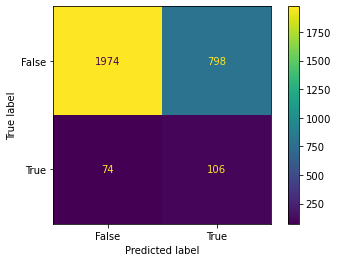

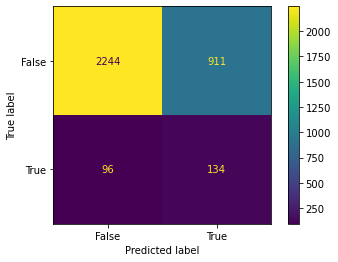

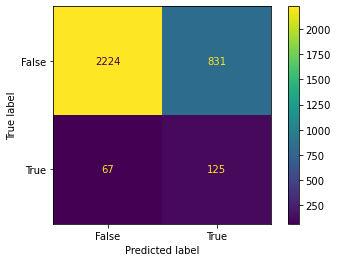

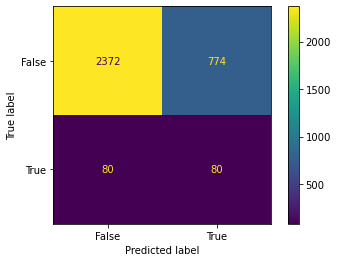

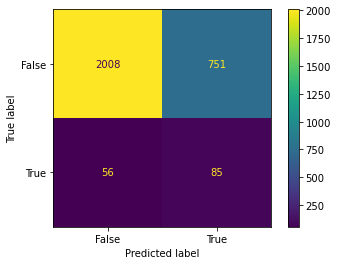

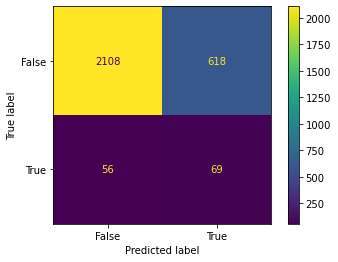

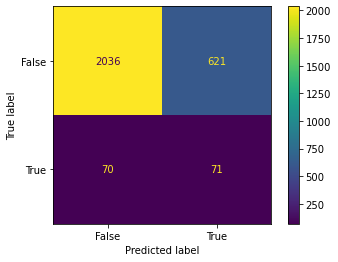

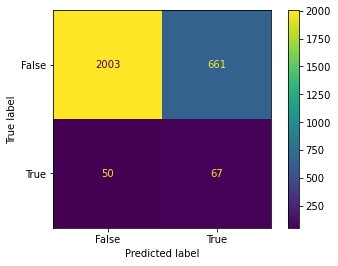

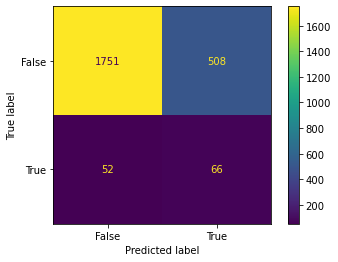

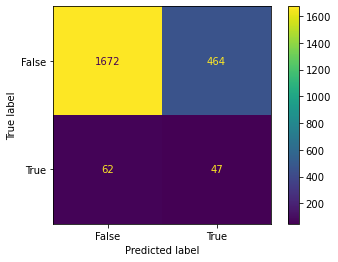

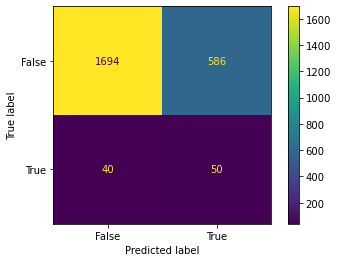

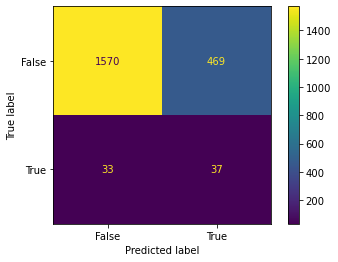

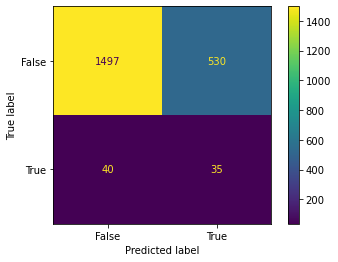

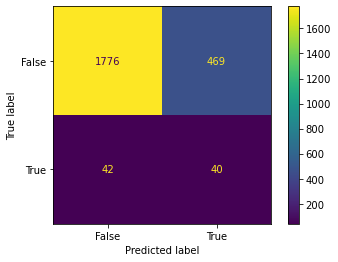

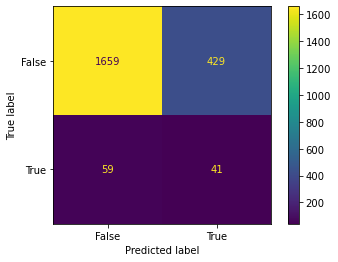

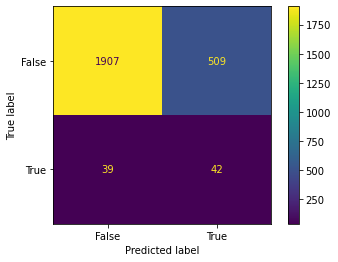

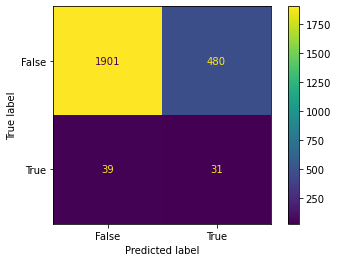

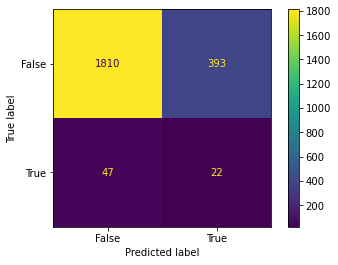

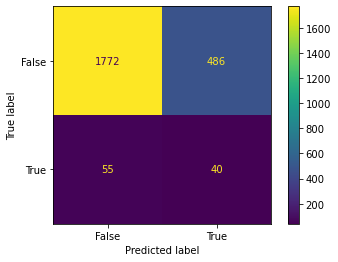

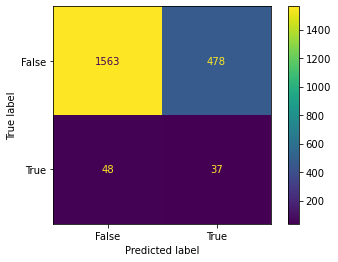

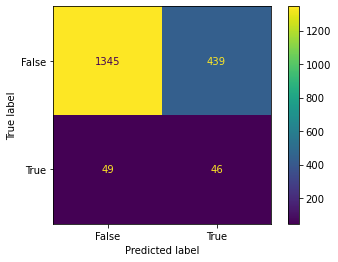

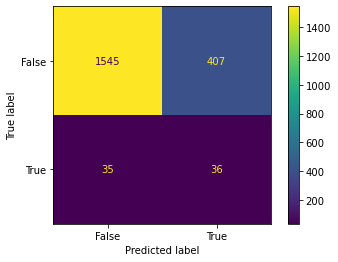

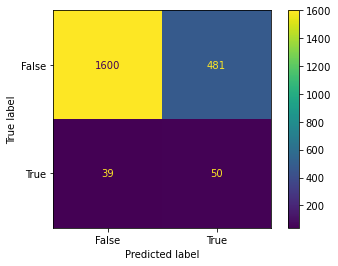

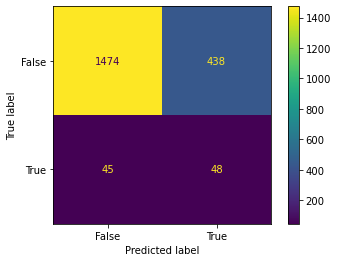

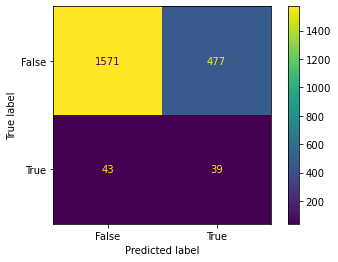

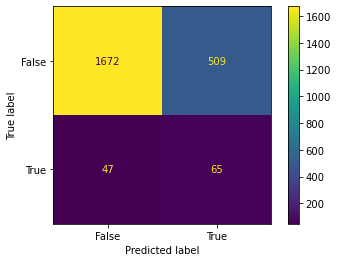

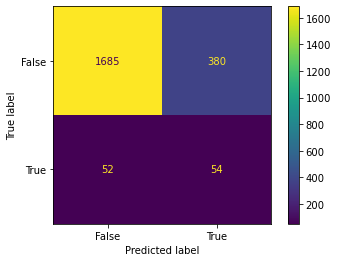

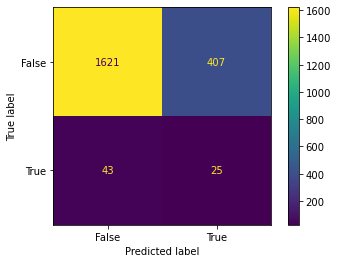

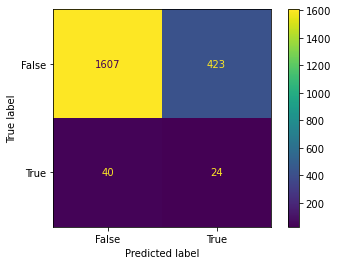

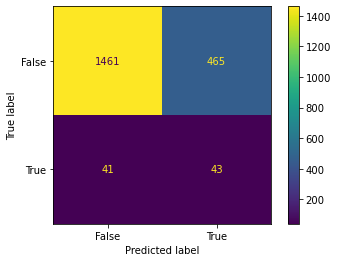

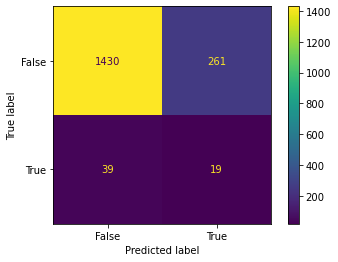

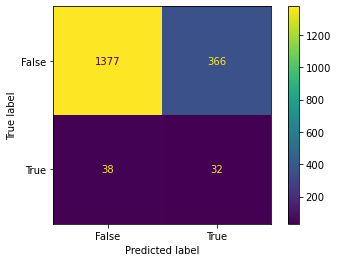

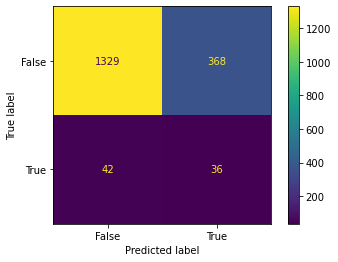

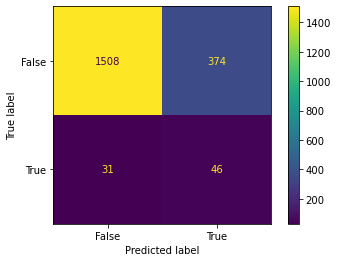

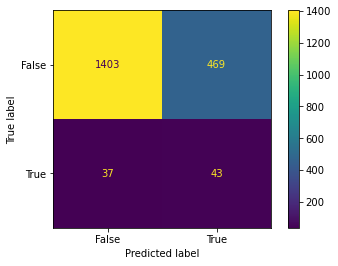

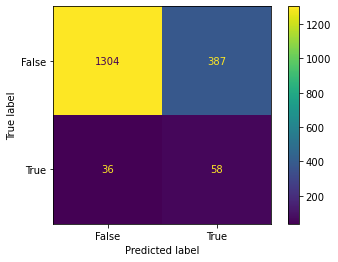

In [541]:
# [plot_confusion_matrix(model_dict[i], X_dict[i], y_dict[i]) for i in model_dict]

In [236]:
import pickle

pickle.dump(model_dict, open(f'model_results/model_36months_ob_{ob_pct}_fruitful_no_salient.pkl', 'wb'))

In [237]:
pickle.dump(result_dict, open(f'model_results/results_ob_{ob_pct}_fruitful_no_salient.pkl', 'wb'))
pickle.dump(X_filt_dict, open(f'model_results/X_filts_ob_{ob_pct}_fruitful_no_salient.pkl', 'wb'))
pickle.dump(X_dict, open(f'model_results/X_tests_ob_{ob_pct}_fruitful_no_salient.pkl', 'wb'))
pickle.dump(y_dict, open(f'model_results/y_tests_ob_{ob_pct}_fruitful_no_salient.pkl', 'wb'))

In [70]:
# X_filt_dict[2]

**Model Audit**

In [238]:
rates = pd.DataFrame()
for i in range(36):
    rates =rates.append(result_dict[i])
    
#     rates.append(pd.Series(data=results[i]['rate'], index=results[i]))

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt

In [240]:
# rates.merge()

In [241]:
max_rates = rates.groupby('t').agg({'rate':'sum'}).rename(columns={'rate':'total_rate'})

In [242]:
rates = rates.merge(max_rates, left_on='t', right_index=True)
rates['prop_crime'] = rates['rate'] / rates['total_rate']

In [243]:
rates_sub = rates[['division', 't', 'prop_crime', 'rate']]

In [244]:
rates_sub['division'].unique()

array(['CENTRAL', 'EASTERN', 'MIDCITY', 'NORTHEASTERN', 'NORTHERN',
       'NORTHWESTERN', 'SOUTHEASTERN', 'SOUTHERN', 'WESTERN'],
      dtype=object)

In [245]:
def fill_in_no_crime(rates_sub, metric='prop_crime'):
    add_rows = []
    for division in rates_sub['division'].unique():
        for t in range(36):
    #         print(rates_sub.loc[(rates_sub['division']==division)&(rates_sub['t']==t), 'prop_crime'])
            try:
                if rates_sub.loc[(rates_sub['division']==division)&(rates_sub['t']==t), metric].values[0] == 0:
                    for i in range(t+1, 36):
                        add_rows.append([division, i, 0, 0])
                    break
            except IndexError:
                for i in range(t+1, 36):
                    add_rows.append([division, i, 0, 0])
                break
    rates_add = rates_sub.append(pd.DataFrame(add_rows, columns=rates_sub.columns))
    return rates_add

In [246]:
rates_add_abs = fill_in_no_crime(rates_sub, metric='rate')

In [247]:
# os.mkdir('figures')

In [248]:
rates_add_abs

,division,t,prop_crime,rate
0,CENTRAL,0,0.082673,0.003680
1,EASTERN,0,0.130574,0.005813
2,MIDCITY,0,0.122476,0.005452
3,NORTHEASTERN,0,0.120469,0.005363
4,NORTHERN,0,0.113057,0.005033
...,...,...,...,...
4,NORTHERN,35,0.158455,0.001514
5,NORTHWESTERN,35,0.013440,0.000128
6,SOUTHEASTERN,35,0.120601,0.001152
7,SOUTHERN,35,0.029380,0.000281


In [249]:
# plt.figure(figsize=(15,10))
# plt.title('Total Proportion of Crime');
# plt.xlabel('Number of Months');
# plt.ylabel('Proportion of Crime');
# sns.lineplot(data=rates_add_abs, x='t', y='rate', hue='division');
# # plt.savefig(f'figures/abs_crime_rate_36months_{ob_pct}_obedience_fruitful.png', dpi=750)

In [250]:
extra_str = '_fruitful_no_salient'

In [251]:
map_division_num

{'NORTHERN': 1,
 'NORTHEASTERN': 2,
 'EASTERN': 3,
 'SOUTHEASTERN': 4,
 'CENTRAL': 5,
 'WESTERN': 6,
 'SOUTHERN': 7,
 'MIDCITY': 8,
 'NORTHWESTERN': 9}

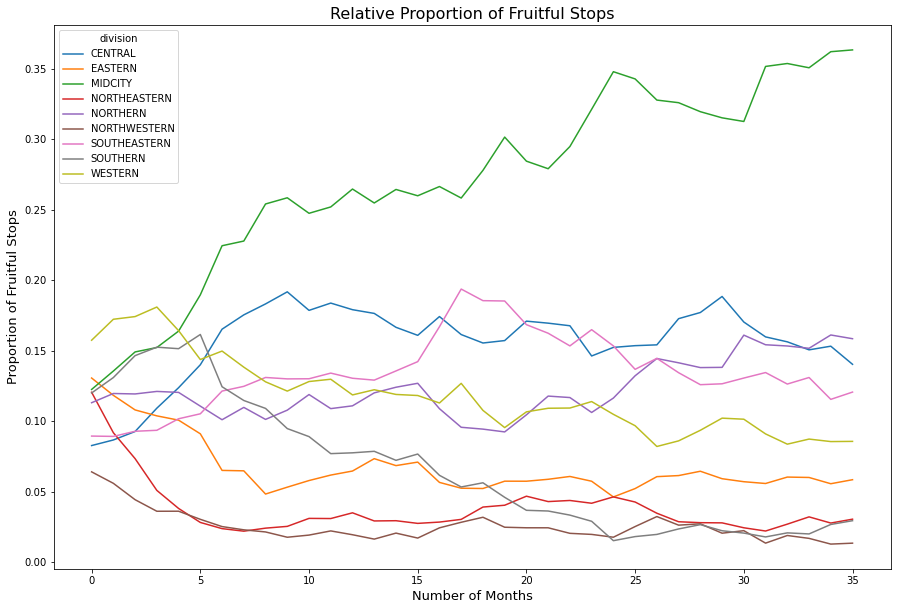

In [252]:
plt.figure(figsize=(15,10))
plt.title('Relative Proportion of Fruitful Stops', fontsize=16);
plt.xlabel('Number of Months', fontsize=13);
plt.ylabel('Proportion of Fruitful Stops', fontsize=13);
sns.lineplot(data=rates_add_abs, x='t', y='prop_crime', hue='division');
plt.savefig(f'figures/total_prop_36months_{ob_pct}_obedience{extra_str}.png', dpi=900, bbox_inches='tight')

In [ ]:
# Assumption: number of officers we allocate directly affects number of stops
# 

In [521]:
rates

[0    0.000033
 1    0.000024
 2    0.000124
 3    0.000019
 4    0.000070
 5    0.000000
 6    0.000072
 7    0.000032
 8    0.000132
 Name: rate, dtype: float64,
 0    0.000157
 1    0.000055
 2    0.000358
 3    0.000026
 4    0.000089
 5    0.000020
 6    0.000330
 7    0.000136
 8    0.000402
 Name: rate, dtype: float64,
 0    0.000255
 1    0.000091
 2    0.000255
 3    0.000058
 4    0.000095
 5    0.000034
 6    0.000302
 7    0.000188
 8    0.000180
 Name: rate, dtype: float64,
 0    0.000111
 1    0.000158
 2    0.000296
 3    0.000084
 4    0.000051
 5    0.000068
 6    0.000280
 7    0.000168
 8    0.000159
 Name: rate, dtype: float64,
 0    0.000222
 1    0.000055
 2    0.000317
 3    0.000026
 4    0.000107
 5    0.000041
 6    0.000151
 7    0.000110
 8    0.000201
 Name: rate, dtype: float64,
 0    0.000137
 1    0.000049
 2    0.000324
 3    0.000058
 4    0.000051
 5    0.000027
 6    0.000201
 7    0.000214
 8    0.000139
 Name: rate, dtype: float64,
 0    0.000144
 

In [131]:
# week_2.stack().sample()

In [132]:
predictions

,pred_fruitful,alloc
,sum,
division,,
CENTRAL,22,0.125000
EASTERN,20,0.113636
MIDCITY,16,0.090909
NORTHEASTERN,26,0.147727
NORTHERN,34,0.193182
NORTHWESTERN,3,0.017045
SOUTHEASTERN,14,0.079545
SOUTHERN,24,0.136364


In [117]:
week_2.groupby('division').agg({'date':'count'}) / len(week_2)

,date
division,
CENTRAL,0.033135
EASTERN,0.096090
MIDCITY,0.160371
NORTHEASTERN,0.104042
NORTHERN,0.109344
NORTHWESTERN,0.066269
SOUTHEASTERN,0.085487
SOUTHERN,0.176938
WESTERN,0.168323


In [ ]:
how_many_discovered()

In [113]:
num_officers = 1800
(predictions['alloc']*num_officers).round()

division
CENTRAL         225.0
EASTERN         205.0
MIDCITY         164.0
NORTHEASTERN    266.0
NORTHERN        348.0
NORTHWESTERN     31.0
SOUTHEASTERN    143.0
SOUTHERN        245.0
WESTERN         174.0
Name: alloc, dtype: float64

In [88]:
# reallocate based on predicted crime rate for regions next week

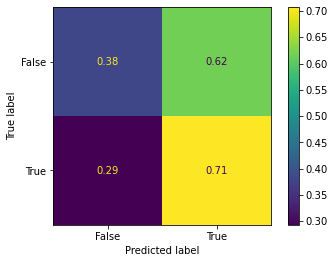

In [87]:
plot_confusion_matrix(lr, X_test, y_test,normalize='true')

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.47      0.38      0.42       105
        True       0.63      0.71      0.67       157

    accuracy                           0.58       262
   macro avg       0.55      0.54      0.54       262
weighted avg       0.56      0.58      0.57       262



In [70]:
sum(y_test == y_pred) / len(y_test)

0.5763358778625954

In [54]:
X_1

,subject_age,subject_race_asian/pacific islander,subject_race_black,subject_race_hispanic,subject_race_other,subject_race_white,subject_sex_female,subject_sex_male,weekday_Friday,weekday_Monday,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-0.855684,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.379379,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.512611,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.924299,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.100923,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135938,1.202755,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135939,-0.169538,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
135940,0.173535,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
135941,-0.992914,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
weekly_pipeline(week_2)

,date,time,division,subject_age,subject_race_asian/pacific islander,subject_race_black,subject_race_hispanic,subject_race_other,subject_race_white,subject_sex_female,subject_sex_male,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour
386,2014-01-06,00:12:00,NORTHEASTERN,25.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
387,2014-01-06,00:23:00,WESTERN,23.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
388,2014-01-06,01:00:00,NORTHWESTERN,51.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
389,2014-01-06,01:05:00,EASTERN,37.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
390,2014-01-06,01:23:00,EASTERN,20.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2014-01-12,23:00:00,WESTERN,26.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,23
1891,2014-01-12,23:00:00,EASTERN,25.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,23
1892,2014-01-12,23:05:00,NORTHWESTERN,28.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,23
1893,2014-01-12,23:10:00,MIDCITY,24.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,23
